In [28]:
# Telling matplotlib to work in the program and not as an external window
%matplotlib inline                  
from nptdms import TdmsFile           # Handling TDMS files
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib as mpl
import numpy as np
from numpy import *
import matplotlib.cm as cm
import time
from scipy.optimize import curve_fit
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns; import pandas as pd
import warnings
from scipy.optimize import OptimizeWarning
from copy import deepcopy            # To completely copy lists and not references
from pandas import DataFrame, Series  # for convenience
import cv2                           # OpenCV for video and image procedures
                                   # generating a folder or deleting files, etc.
import multiprocessing as mp         # This is for preventing large videos to take too much internal memory
import shutil                        # Deleting folders
plt.rcParams.update({'font.size': 14})
import matplotlib.cm as cm
import statistics as stats
import moviepy.video.io.ImageSequenceClip

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def calcvelocity(rrange,sigma,vdiff,A,vmin):
    sigmaterm = 2*sigma**2
    distances = np.linspace(0,rrange,100)
    I = A*np.exp(-distances**2/sigmaterm)
    return distances, vdiff*np.exp(-2*I/A)+vmin

def solution(phi,t,vmax,D_0):
    return exp(-t*vmax**2/(4*D_0))/(4*np.pi) * (2+exp(t*vmax**2*sin(phi)**2/(4*D_0))*sqrt(np.pi/(D_0*t))*t*vmax*sin(phi) + exp(t*vmax**2*sin(phi)**2/(4*D_0))*sqrt(np.pi*t/D_0)*vmax*sin(phi)*scipy.special.erf(sqrt(t/D_0)*vmax*sin(phi)/2))

def linfunction(xpoints,minput,ninput):
    return minput * xpoints + ninput

def linMSD(xpoints,minput):
    return minput * xpoints

def linMSD2(xpoints,minput,ninput):
    return minput * xpoints + ninput

def msd_1d(x):
    result = np.zeros_like(x)
    for i in range(1,len(x)):
        result[i] = np.average((x[i:] - x[:-i])**2)
    return result

def chi2(ydata,Nparams,f, *params):
    res = ydata - f(*params)
    redchi2 = sum(res**2)/(len(ydata)-Nparams)
    return res, redchi2

def acfangle_1d(x):
    result = np.zeros_like(x)
    for i in range(1,len(x)):
        result[i] = np.average(np.cos((x[i:] - x[:-i])*np.pi/180))
    result[0] = 1
    return result

def expfun(x,lp):
    return np.exp(-x/lp)

def vectorlength(x): return np.sqrt(pow(x[0],2)+pow(x[1],2))

def msd_2d(x,y):
    result = np.zeros_like(x)
    for i in range(1,len(x)): result[i] = np.average(pow(x[i:] - x[:-i],2)+pow(y[i:] - y[:-i],2))
    return result

def calcdrifttheory(v,r,tau,delay,base):
    dv = np.gradient(v,base)
    return tau/2*(1-delay/tau)*v*dv+tau*v**2/r

def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)

def fitparallel(x,Dfit,mu):
    sigma_omega_squared = 2*Dfit*mindelay/(R*1e6)**2
    sigma_yomega_squared = (1-np.exp(-2*sigma_omega_squared))/2
    v_omega = np.exp(sigma_omega_squared/2)*maxvelocity
    sigma_parallel_squared = (1-sigma_yomega_squared)*v_omega**2*mindelay**2-np.exp(-sigma_omega_squared)*v_omega**2*mindelay**2+2*Dfit*mindelay
    return gauss(x,sigma_parallel_squared,mu)

def fitperpendicular(x,Dfit,mu):
    sigma_omega_squared = 2*Dfit*mindelay/(R*1e6)**2
    sigma_yomega_squared = (1-np.exp(-2*sigma_omega_squared))/2
    v_omega = np.exp(sigma_omega_squared/2)*maxvelocity
    sigma_perpendicular_squared = sigma_yomega_squared*v_omega**2*mindelay**2+2*Dfit*mindelay
    return gauss(x,sigma_perpendicular_squared,mu)

def gauss(x,sigma_squared,mu): return 1/np.sqrt(2*np.pi*sigma_squared)*np.exp(-(x-mu)**2/(2*sigma_squared))

In [29]:
filenumber = 1
folder = "/Users/alex/Documents/Measurements/201216 - Alex 2 particles"

flashtime = 0.01
pxtomum=0.0533#0.0719e-6
maxpower = 2.4
steps = 13
R = 2.19e-6/2
diameter = R*2*1e6
T = 273.15+22
kB = 1.38064852e-23
eta=2.414e-5*10**(247.8/(T-140))
D_0 = kB*T/(6*np.pi*eta*R)
D_0 = 3.85e-14

amplitude = 1
start_time = time.time()   
if filenumber < 10: tdms_file = TdmsFile(folder+"/Test_00"+str(filenumber)+"_module.tdms")
else:
    if filenumber < 100: tdms_file = TdmsFile(folder+"/Test_0"+str(filenumber)+"_module.tdms")
    else: filetdms_file = TdmsFile(folder+"/Test_"+str(filenumber)+"_module.tdms")
print("--- %s seconds ---" % round((time.time() - start_time),2))

printnum = filenumber
savefolderplus = '.'
Xc = tdms_file['Data']['Xc']
Yc = tdms_file['Data']['Yc']
velocitytheo = tdms_file['Data']['Velocity']
intensitytheo = tdms_file['Data']['Intensity']
angletheo = tdms_file['Data']['Angle']
xolaser = tdms_file['Data']['Xh']
yolaser = tdms_file['Data']['Yh']
Nfound = tdms_file['Data']['N']
Nlaser = tdms_file['Data']['NLaser']
delaywave = tdms_file['Data']['Delays']
iterationtime = tdms_file['Data']['Iterationtime']
programtime = tdms_file['Data']['Programtime']
phase = tdms_file['Data']['Phase']
p = tdms_file.object().properties
delay = int(p['Delay'])
noise = int(p['Sigmanoise'])
boundaryradius = 2*p['Boundary']
offset = -p['Offset']
sigmavelo = p['Sigmavelo']
vmin = p['Vmin']
vmax = p['Vmax']
vfactor = vmax - vmin
firstlength = len(Nfound)
maxlength = 0
for i in range(firstlength):
    if phase[i] == 0: maxlength += 1
dt = p['CycleTime']
videosize = p['Xsize']
timewave=np.linspace(0,maxlength*dt,maxlength)
dtprogram = 13.6e-3                             #time of the program (tracking + calculation) [s]
dtsendtoadwin = 1e-3                            #time to send signal from PC to Adwin [s]
dttransferfromcamtocom = 1e-3                   #time to send from cam to PC (unknown) [s]
dtframetransfer = videosize * 1.9176e-6         #time for frametransfer [s]
dtreadout = (1032/(27e6) + 1.9176e-6)*videosize #time to readout the cam [s]
dtprogram = np.mean(programtime)*1e-3#6.3e-3
dtexphalf = flashtime/2
dtcamtoPC = dtPCtoADwin = 1e-3
mindelay = dtexphalf + dtframetransfer + dtreadout + dtcamtoPC + dtprogram + dtPCtoADwin
delaydt = mindelay +(delay-1)*dt

print('size of the video = ',videosize)
print('length of the movie = ',maxlength)

--- 14.26 seconds ---
size of the video =  700
length of the movie =  10000


/Users/alex/anaconda/lib/python3.5/site-packages/nptdms/tdms.py:1097: UserWarning: 'TdmsFile.object' is deprecated and will be removed in a future release. Use TdmsFile.properties to access properties of the root object, TdmsFile[group_name] to access a group object and TdmsFile[group_name][channel_name] to access a channel object.
  warnings.warn(message)
/Users/alex/anaconda/lib/python3.5/site-packages/nptdms/tdms.py:1097: UserWarning: 'TdmsFile.objects' is deprecated and will be removed in a future release. Use TdmsFile.groups() to access all groups in the file, and group.channels() to access all channels in a group.
  warnings.warn(message)


Trajectory length
[9998. 9998.]


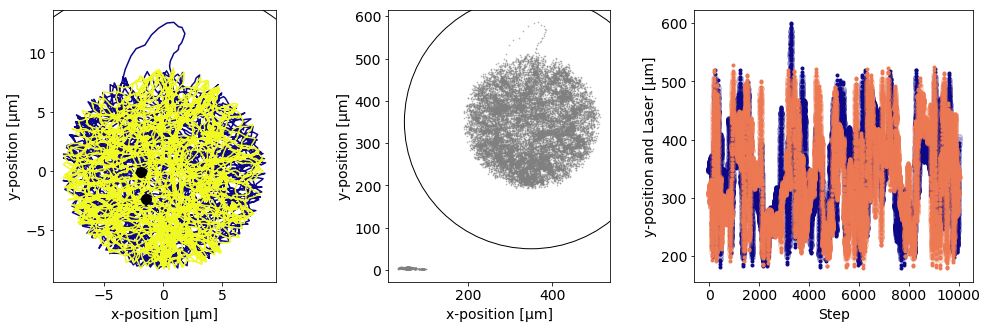

In [30]:
pnumber = int(stats.mode(Nfound))
maxnumber = int(max(Nfound))
particles = np.zeros((maxlength,pnumber,8))
lastone = np.zeros((pnumber,2))
pre = np.zeros((maxlength,maxnumber,8))
test = np.zeros((int(Nfound[0]),2))
for i in range(int(Nfound[0])):             #Sort the particles in the first frame according to there 
    test[i,0] = i                           #distance to the center, particles outside the boundary are not important
    test[i,1] = np.sqrt(pow(Xc[i]-videosize/2,2)+pow(Yc[i]-videosize/2,2))
check = sorted(test, key=lambda test: test[1])
order = np.zeros(int(Nfound[0]))
for i in range(int(Nfound[0])):
    test2 = check[i]
    order[i] = test2[0]  
count = 0
for j in range(int(Nfound[0])):
    pre[0,j,0] = Xc[int(order[j])]
    pre[0,j,1] = Yc[int(order[j])]
    pre[0,j,2] = velocitytheo[int(order[j])]
    pre[0,j,3] = angletheo[int(order[j])] 
    pre[0,j,4] = xolaser[int(order[j])]
    pre[0,j,5] = yolaser[int(order[j])]
    pre[0,j,6] = intensitytheo[int(order[j])]           
count = int(Nfound[0])
for i in range(1,maxlength):               #Write all position in a first wave
    for j in range(int(Nfound[i])):
        pre[i,j,0] = Xc[count]
        pre[i,j,1] = Yc[count]
        pre[i,j,2] = velocitytheo[count]
        pre[i,j,3] = angletheo[count]
        pre[i,j,4] = xolaser[count]
        pre[i,j,5] = yolaser[count]
        pre[i,j,6] = intensitytheo[count]
        count += 1
        
sumup = Nfound[0]                         #sumup - if the first frames are without a particle, they willbe cut off
if Nfound[0] != 0: starttraj = 0
particles[0,:,:] = pre[0,:pnumber,:]
diff = 0
for i in range(1,maxlength):
    if sumup != 0:
        check = False; occupied = np.zeros((int(Nfound[i]),2))
        for p in range(2):                    #first check those particles which where found in the frame before
            for j in range(pnumber):
                if p == 0:
                    if particles[i-1,j,0] != 0: check = True
                else:
                    if particles[i-1,j,0] == 0: check = True          
                if check == True:         
                    sumup += Nfound[i]
                    if particles[i-1,j,0] != 0:    #remember how long the particle is lost
                        lastone[j,0] = i-1
                        lastone[j,1] = 0
                    else: lastone[j,1] += 1
                    xpre = particles[int(lastone[j,0]),j,0]
                    ypre = particles[int(lastone[j,0]),j,1]
                    mindist = 100; minnum = 666
                    for k in range(int(Nfound[i])):     #Sort the trajectories be comparing the distance between the positions
                        if occupied[k,0] == 0:
                            dist = np.sqrt(pow(xpre-pre[i,k,0],2)+pow(ypre-pre[i,k,1],2))
                            if dist < mindist:
                                mindist = dist
                                minnum = k
                                #print('i = ',i,' - j = ',j,' - mindist = ',round(mindist,1),' - minnum = ',minnum)
                    if minnum != 666:              #Write the shortest one
                        particles[i,j,:4] = pre[i,minnum,:4]
                        particles[i,j,6] = pre[i,minnum,6]
                        occupied[minnum,0] = 1                 
                    mindist = 0.2; minnum = 666     #sort the laser position
                    for k in range(int(Nfound[i])):
                        if particles[i,j,0] != 0:
                            if occupied[k,1] == 0:
                                dist = np.sqrt(pow(particles[i-diff,j,0]-pre[i,k,4],2)+pow(particles[i-diff,j,1]-pre[i,k,5],2))
                                #print('i = ',i,' - j = ',j,' - k = ',k,' - dist = ',round(dist,1))
                                if abs(dist - offset) < mindist:
                                    mindist = dist
                                    minnum = k
                    if minnum != 666:              #Write the shortest one
                        particles[i,j,4:6] = pre[i,minnum,4:6]
                        occupied[minnum,1] = 1                           
    else:
        if Nfound[i] != 0:
            starttraj = i
            sumup += Nfound[i]
            for j in range(int(Nfound[i])): particles[i,j,:] = pre[i,j,:]
    #print('i = ',i,' - Nfound = ',Nfound[i],' - x[i,0] = ',int(particles[i,0,0]))

for i in range(1,maxlength):
    for j in range(pnumber):
        if particles[i,j,0] == 0:
            particles[i,j,0] = np.nan
            particles[i,j,1] = np.nan 
        if particles[i,j,4] == 0: 
            particles[i,j,4] = np.nan
            particles[i,j,5] = np.nan
particles[:,:,0:2] = (particles[:,:,0:2]-videosize/2)*pxtomum
particles[:,:,4:6] = (particles[:,:,4:6]-videosize/2)*pxtomum
save = particles.copy()
cutlastpoints = False
trajlength = np.zeros(pnumber)
for j in range(pnumber):
    lastfound = 0; out = True
    for i in range(starttraj+1,maxlength):
        if out == True:
            if particles[i,j,0] != particles[i,j,0]:
                lastfound = int(i-1)
                count = 1; check = True
                while check == True:
                    if lastfound+count < maxlength:
                        if particles[lastfound+count,j,0] == particles[lastfound+count,j,0]:
                            #print('j = ',j,' - i = ',i,' - gap = ',count)
                            check = False
                        else: count +=1
                            #print('i = ',i,' count =',count)
                    else: count += 1 #= 150
                    if count == 200:
                        print('Failed at j = ',j,' - i = ',i)
                        check = False
                        trajlength[j] = lastfound
                        particles[lastfound:,j,0] = np.nan
                        particles[lastfound:,j,1] = np.nan
                        out = False
                #print('particle number = ',j,' - position = ',i,' gap length = ',count)
                if out == True:
                    #for k in range(0,count+1):
                    #    print('...... i = ',lastfound+k,' - x = ',round(particles[lastfound+k,j,0],1))
                    for k in range(1,count+1):
                        particles[lastfound+k,j,0] = particles[lastfound,j,0]+(k/(count+1))*(particles[lastfound+count,j,0]-particles[lastfound,j,0])
                        particles[lastfound+k,j,1] = particles[lastfound,j,1]+(k/(count+1))*(particles[lastfound+count,j,1]-particles[lastfound,j,1])
                        particles[lastfound+k,j,2] = particles[lastfound,j,2]+(k/(count+1))*(particles[lastfound+count,j,2]-particles[lastfound,j,2])
                        particles[lastfound+k,j,3] = particles[lastfound,j,3]+(k/(count+1))*(particles[lastfound+count,j,3]-particles[lastfound,j,3])
                        particles[lastfound+k,j,6] = particles[lastfound,j,6]+(k/(count+1))*(particles[lastfound+count,j,6]-particles[lastfound,j,6])
                        #particles[lastfound+k,j,4] = particles[lastfound,j,4]+(k/(count+1))*(particles[lastfound+count,j,4]-particles[lastfound,j,4])
                        #particles[lastfound+k,j,5] = particles[lastfound,j,5]+(k/(count+1))*(particles[lastfound+count,j,5]-particles[lastfound,j,5])
                    #print('AFTER')
                    #for k in range(0,count+1):
                    #    print('...... i = ',lastfound+k,' - x = ',round(particles[lastfound+k,j,0],1))
                    #print('----------')
            if i == firstlength-2: 
                trajlength[j] = i
particlessave = particles.copy()
if starttraj != 0:
    maxlength = int(maxlength-starttraj)
    particles = np.zeros((maxlength,pnumber,6))
    particles = particlessave[starttraj:,:,:]
if cutlastpoints == True:
    particlessave = particles.copy()
    delete = firstlength - trajlength[0]
    maxlength = int(maxlength-delete)
    particles = np.zeros((maxlength,pnumber,6))
    particles = particlessave[:maxlength,:,:]
timewave=np.linspace(0,maxlength*dt,maxlength)

for i in range(maxlength):
    for j in range(pnumber):
        if particles[i,j,6] > 1: particles[i,j,6] = 1

print('Trajectory length')                  
print(trajlength)

colorwave = cm.plasma(np.linspace(0, 1, pnumber))
fig=plt.figure(1, figsize = (17,5) )
ax = plt.subplot(1,3,1)
ax.set_aspect('equal')
for i in range(pnumber):
    ax.scatter(particles[starttraj,i,0],particles[starttraj,i,1],color='k',s = 100,zorder=3)
    ax.plot(particles[:,i,0],particles[:,i,1],color=colorwave[i],zorder=2)
    #ax.scatter(particles[:,i,4],particles[:,i,5],color=colorwave[i],s = 30,zorder=3)
    #ax.plot(save[:,i,0],save[:,i,1],zorder=1)
circle2 = plt.Circle((0, 0), boundaryradius*pxtomum, color='k', fill=False)
ax.add_artist(circle2)
plt.xlabel('x-position [µm]')
plt.ylabel('y-position [µm]')

ax2 = plt.subplot(1,3,2)
ax2.set_aspect('equal')
plt.scatter(Xc,Yc,s=0.5,color='grey',alpha = 0.5)
circle2 = plt.Circle((videosize/2, videosize/2), boundaryradius, color='k', fill=False)
ax2.add_artist(circle2)
plt.xlabel('x-position [µm]')
plt.ylabel('y-position [µm]')

ax3 = plt.subplot(1,3,3)
xwave = np.linspace(0,maxlength,maxlength,endpoint=False)
colorwave = cm.plasma(np.linspace(0, 1, 2*pnumber))
for j in range(pnumber):
    ax3.scatter(xwave,pre[:,j,1],marker='o',c=colorwave[2*j],alpha=0.2)
    ax3.scatter(xwave,pre[:,j,5],marker='.',c=colorwave[2*j])
#plt.xlim([0,3000])
plt.xlabel('Step')
plt.ylabel('y-position and Laser [µm]')
plt.show()

In [31]:
'''
starthere = 0
endhere = 1000

boundmum = boundaryradius*pxtomum/2
savefolder = '.'
factor =  1.3
for k in range(starthere,endhere):
    string_temp = savefolder + '/MoviePic/'
    if not os.path.exists(string_temp): os.makedirs(string_temp)
    fig=plt.figure(1, figsize = (5,5) )
    ax = plt.subplot(1,1,1)
    ax.set_aspect('equal')
    for i in range(pnumber):
        circle2 = plt.Circle((particles[k,i,0],particles[k,i,1]), R*1e6, color='grey', fill=False)
        ax.add_artist(circle2)
        circle2 = plt.Circle((particles[k,i,4],particles[k,i,5]), 0.2, color='green', fill=True)
        ax.add_artist(circle2)
    plt.xlabel('x-position [µm]')
    plt.ylabel('y-position [µm]')
    circle2 = plt.Circle((0, 0), boundaryradius*pxtomum/2, color='k', fill=False)
    ax.add_artist(circle2)
    ax.set_title('t = '+str(round(k*dt,1))+' s')
    ax.set_xlim([-factor*boundmum,factor*boundmum])
    ax.set_ylim([-factor*boundmum,factor*boundmum])

    plt.savefig(string_temp +str(k)+'.png', format='png')
    plt.close(fig)
    
import moviepy.video.io.ImageSequenceClip
image_folder= string_temp
fps= 1/dt

image_files = []
for i in range(starthere,endhere):
    image_files.append(string_temp+str(i)+'.png')
    
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('Movie'+str(filenumber)+'.mp4')
'''

"\nstarthere = 0\nendhere = 1000\n\nboundmum = boundaryradius*pxtomum/2\nsavefolder = '.'\nfactor =  1.3\nfor k in range(starthere,endhere):\n    string_temp = savefolder + '/MoviePic/'\n    if not os.path.exists(string_temp): os.makedirs(string_temp)\n    fig=plt.figure(1, figsize = (5,5) )\n    ax = plt.subplot(1,1,1)\n    ax.set_aspect('equal')\n    for i in range(pnumber):\n        circle2 = plt.Circle((particles[k,i,0],particles[k,i,1]), R*1e6, color='grey', fill=False)\n        ax.add_artist(circle2)\n        circle2 = plt.Circle((particles[k,i,4],particles[k,i,5]), 0.2, color='green', fill=True)\n        ax.add_artist(circle2)\n    plt.xlabel('x-position [µm]')\n    plt.ylabel('y-position [µm]')\n    circle2 = plt.Circle((0, 0), boundaryradius*pxtomum/2, color='k', fill=False)\n    ax.add_artist(circle2)\n    ax.set_title('t = '+str(round(k*dt,1))+' s')\n    ax.set_xlim([-factor*boundmum,factor*boundmum])\n    ax.set_ylim([-factor*boundmum,factor*boundmum])\n\n    plt.savefig(st

In [35]:
4*R

4.38e-06

In [37]:
distancetocenter=[]                                    #Calc velocity 
distancetocenter=np.sqrt(pow(particles[:,0,0],2)+pow(particles[:,0,1],2))
oldstartpoint = []; oldendpoint =[]
if distancetocenter[0] < boundaryradius*pxtomum/2:
    oldstartpoint.append(0)
    check = 0
else: check = 1; remi = -1   
count = 0
for i in range(1,maxlength):
    if distancetocenter[i] > boundaryradius*pxtomum/2:
        if check == 0:
            remi = i
            check = 1
        count += 1
    if check == 1: 
        if distancetocenter[i] < boundaryradius*pxtomum/2:
            check = 0
            if remi != -1:
                oldstartpoint.append(i)
                oldendpoint.append(remi)
            else: oldstartpoint.append(i)
        else: count += 1   
if check == 1: oldendpoint.append(remi)
else: oldendpoint.append(maxlength-1)
    
timeclosewave = []; count = 0
for i in range(1,maxlength): 
    if distancetocenter[i] < 4*R*1e6: count += 1
    else:
        if distancetocenter[i-1] < 4*R*1e6:
            timeclosewave.append(count*dt)
            count = 0
    
realvelocity = np.zeros(maxlength);stepsize = np.zeros(maxlength)    
movingvector = np.zeros((maxlength,2)); directionvector = np.zeros((maxlength,2))
directionvector[:,0] = np.cos(particles[:,0,3]*np.pi/180)
directionvector[:,1] = np.sin(particles[:,0,3]*np.pi/180)
for i in range(2,maxlength):                           #Calc projection of the velocity in the required direction
    movingvector[i,0] = particles[i,0,0]-particles[i-1,0,0]
    movingvector[i,1] = particles[i,0,1]-particles[i-1,0,1]
    stepsize[i] = abs(np.dot(directionvector[i-2,:], movingvector[i,:]))
    realvelocity[i] = stepsize[i]/dt
   
particlesdisplay = np.zeros((maxlength,pnumber,8))
particlesdisplay[:,:,:] = particles[:,:,:]
for i in range(pnumber):
    particlesdisplay[:,i,:2] -= particles[:,1,:2]
    particlesdisplay[:,i,4:6] -= particles[:,1,:2]

[5.231800142675638, 0.5180000141263008, 1.0360000282526016, 1.346800036728382, 2.3828000649809837, 1.864800050854683, 5.957000162452459, 1.6576000452041626, 0.8806000240147114, 8.080800220370293, 1.1914000324904919, 3.833200104534626, 1.1914000324904919, 2.590000070631504, 0.05180000141263008, 0.05180000141263008, 11.810400322079659, 0.7252000197768211, 1.7612000480294228, 1.6058000437915325, 2.590000070631504, 1.1914000324904919, 1.0878000296652317, 0.8806000240147114, 2.020200055092573, 0.05180000141263008, 0.05180000141263008, 0.8806000240147114, 0.20720000565052032, 0.10360000282526016, 0.05180000141263008, 1.916600052267313, 4.195800114423037, 3.9886001087725163, 0.621600016951561, 1.1396000310778618, 2.020200055092573, 1.346800036728382, 0.7770000211894512, 0.7770000211894512, 1.243200033903122, 0.05180000141263008, 2.9008000791072845, 1.0878000296652317, 0.2590000070631504, 3.108000084757805, 6.47500017657876, 3.5224000960588455, 1.864800050854683, 1.346800036728382, 1.398600038

(array([39., 26.,  9.,  3.,  3.,  2.,  1.,  0.,  0.,  1.]),
 array([ 0.0518    ,  1.22766003,  2.40352007,  3.5793801 ,  4.75524013,
         5.93110016,  7.10696019,  8.28282023,  9.45868026, 10.63454029,
        11.81040032]),
 <a list of 10 Patch objects>)

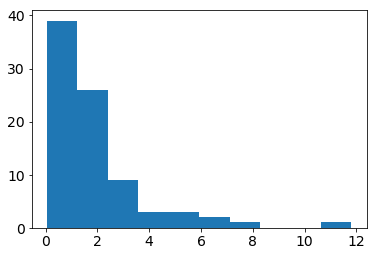

In [38]:
plt.hist(timeclosewave)

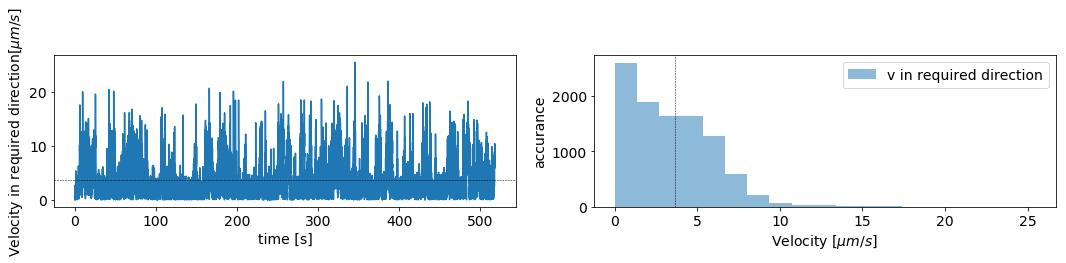

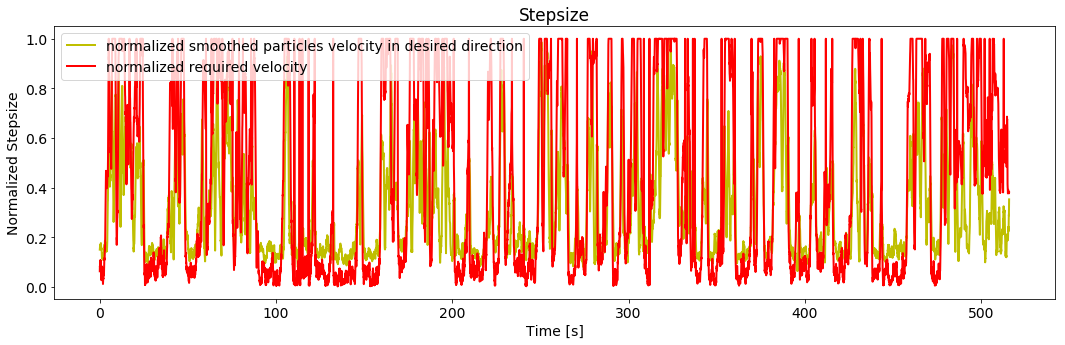

single particle =  3.671  +-  12.557  µm/s   max velocity =  25.436   µm/s
mean distance to the center =  5.19  µm
102
11.81467149247567


In [33]:
velocity = np.zeros(maxlength);stepsize = np.zeros(maxlength)    
movingvector = np.zeros((maxlength,2)); directionvector = np.zeros((maxlength,2))
directionvector[:,0] = np.cos(particlesdisplay[:,0,3]*np.pi/180)
directionvector[:,1] = np.sin(particlesdisplay[:,0,3]*np.pi/180)
for i in range(2,maxlength):                           #Calc projection of the velocity in the required direction
    movingvector[i,0] = particlesdisplay[i,0,0]-particlesdisplay[i-1,0,0]
    movingvector[i,1] = particlesdisplay[i,0,1]-particlesdisplay[i-1,0,1]
    stepsize[i] = abs(np.dot(directionvector[i-2,:], movingvector[i,:]))
    velocity[i] = stepsize[i]/dt
meanvelocity = np.mean(velocity)

binwave = np.linspace(0,max(velocity),20)
fig=plt.figure(1, figsize = (15,3.5) )
plt.subplot(1,2,1)
plt.xlabel('time [s]')
plt.ylabel('Velocity in required direction[$\mu m/s$]')
plt.plot(np.arange(maxlength)*dt,velocity)
plt.axhline(y=np.mean(velocity),linewidth=0.5, color = 'k',linestyle='--')
plt.subplot(1,2,2)
#plt.hist(velocitywithdiffusion, bins=binwave,alpha = 0.5,label='v with diffusion')
plt.hist(realvelocity, bins=binwave,alpha = 0.5,label='v in required direction')
plt.axvline(x=meanvelocity,linewidth=0.5, color = 'k',linestyle='--')
plt.xlabel('Velocity [$\mu m/s$]')
plt.ylabel('accurance')
#plt.text(3,0,'mean step size 1: {:.2f} µm/s'.format(np.mean(velocity)),fontsize=12)
plt.legend()
plt.tight_layout() 
plt.savefig('Histogram Stepsize'+str(printnum)+'.pdf', format='pdf')
plt.show() 

fig=plt.figure(1, figsize = (15,5) )
plt.title('Stepsize')
plt.xlabel('Time [s]')
plt.ylabel('Normalized Stepsize')
smoothvalue = 20
smoothit = smooth(velocity,smoothvalue)
xsmooth=np.linspace(0,dt*maxlength-2*smoothvalue*dt,maxlength-2*smoothvalue,endpoint=False)
plt.plot(xsmooth,smoothit[smoothvalue:maxlength-smoothvalue]/max(smoothit), 'y-', lw=2,label='normalized smoothed particles velocity in desired direction')
#plt.plot(xsmooth,smoothit[smoothvalue:maxlength-smoothvalue]/mean(smoothit), 'y-', lw=2,label='normalized smoothed particles speed')
plt.plot(xsmooth,particles[smoothvalue:maxlength-smoothvalue,0,2], 'r-', lw=2,label='normalized required velocity')
plt.legend()
plt.tight_layout() 
plt.savefig('Stepsize vs time'+str(printnum)+'.pdf', format='pdf')
plt.show()

#np.savetxt('Datavelo'+str(printnum)+'.txt', np.transpose([velocity,smoothit,velo[:,0]]),fmt='%1.6f')
print('single particle = ',round(np.mean(velocity),3),' +- ',round(np.var(velocity),3),' µm/s   max velocity = ',round(max(velocity),3),'  µm/s')
print('mean distance to the center = ',round(np.mean(distancetocenter),2),' µm')

count = 0
for i in range(1,maxlength):
    if particles[i,0,2] >= 0.5 and particles[i-1,0,2] < 0.5: count += 1
print(count)
print(count*60/(dt*maxlength))

/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:40: RuntimeWarning: overflow encountered in exp
/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in double_scalars


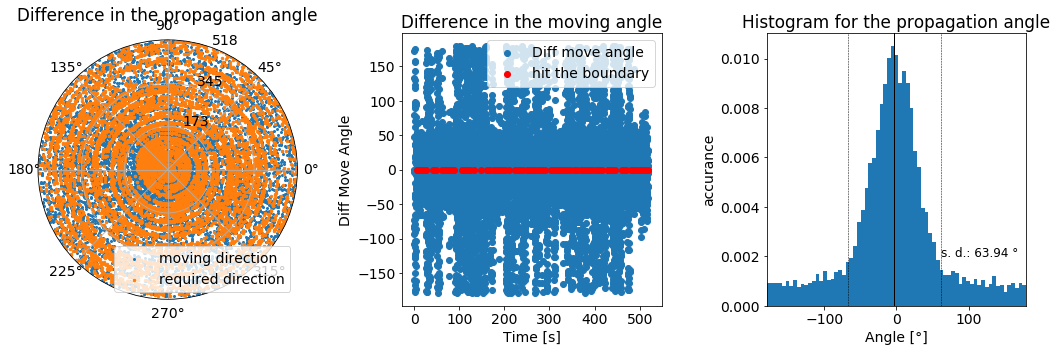

In [7]:
laserangle = np.zeros(maxlength);diffangle = np.zeros(maxlength)
moveangle = np.zeros(maxlength);diffmoveangle = np.zeros(maxlength)
delaylaserangle = 0   #in frames
delaydirection = 2    #in frames
angle = particles[:,0,3]

distancetocenter=[]
distancetocenter=np.sqrt(pow(particles[:,0,0],2)+pow(particles[:,0,1],2))
for i in range(maxlength):  
    dx = particles[i,0,0]-particles[i,0,4]             #Calc the angle of the laser
    dy = particles[i,0,1]-particles[i,0,5]
    laserangle[i] = np.arctan(dy/dx)*180/np.pi
    #laserangle[i] = - laserangle[i]
    if laserangle[i] != laserangle[i]: laserangle[i] = 90
    if dx > 0:
        if dy < 0: laserangle[i] += 360
    else: laserangle[i] += 180
    if laserangle[i]>360: laserangle[i] -= 360
    if i >= delaylaserangle:                      #Calc difference between required laser angle and real angle
        diffangle[i] = particles[i-delaylaserangle,0,3] - laserangle[i]
        if abs(diffangle[i]) > 180:
                if diffangle[i] > 0: diffangle[i] -= 360
                else: diffangle[i] += 360
        if abs(diffangle[i]) > 40: diffangle[i] = 0
            #print('Error laser? : i = ',i)
for i in range(1,maxlength):
    dx = particles[i,0,0]-particles[i-1,0,0]      #Calc moving direction
    dy = particles[i,0,1]-particles[i-1,0,1]
    moveangle[i] = np.arctan(dy/dx)*180/np.pi
    if moveangle[i] != moveangle[i]: moveangle[i] = 90
    if dx > 0:
        if dy < 0: moveangle[i] += 360
    else: moveangle[i] += 180
    if moveangle[i]>360: moveangle[i] -= 360
    if moveangle[i]<0: moveangle[i] += 360
    if i >= delaydirection:                       #Calc angle difference between required direction and real direction
        diffmoveangle[i] = particles[i-delaydirection,0,3] - moveangle[i]
        if abs(diffmoveangle[i]) > 180:
            if diffmoveangle[i] > 0: diffmoveangle[i] -= 360
            else: diffmoveangle[i] += 360
moveangle[0] = moveangle[1]
r = timewave
theta = moveangle*pi/180
theta2 = particles[:,0,3]*pi/180
theta3 = laserangle*pi/180

phiwave = np.linspace(0,2*np.pi,360,endpoint=False)
anglewave = np.linspace(-90,270,360,endpoint=False)
solutionwave = np.zeros(360)
for i in range(360): solutionwave[i] = solution(phiwave[i],dt,vmax,D_0)
solutionwave[:] /= sum(solutionwave[:]) 

angle2 = np.zeros(maxlength); angle2 = angle.copy()
for i in range(1,maxlength):
    if angle2[i] == 0:
        if i+2 < maxlength: angle2[i] = (angle2[i-1]+angle2[i+2])/2
        else: angle2[i] = angle2[i-1]
    if angle2[i] == 360:
        if i+2 < maxlength: angle2[i] = (angle2[i-1]+angle2[i+2])/2
        else: angle2[i] = angle2[i-1]
newangle = np.zeros(maxlength); newangle = angle2.copy()    #MSD for the theoretic moving direction
diff = np.zeros(3)
for i in range(1,maxlength):
    diff[0] = abs(newangle[i]-newangle[i-1])
    diff[1] = abs(newangle[i]-newangle[i-1]+360)
    diff[2] = abs(newangle[i]-newangle[i-1]-360)
    mini = min(diff)
    if mini != diff[0]:
        if mini == diff[1]: newangle[i:] += 360
        else: newangle[i:] -= 360
newmoveangle = np.zeros(maxlength); newmoveangle = moveangle.copy()    #MSD for the theoretic moving direction
diff = np.zeros(3)
for i in range(1,maxlength):
    diff[0] = abs(newmoveangle[i]-newmoveangle[i-1])
    diff[1] = abs(newmoveangle[i]-newmoveangle[i-1]+360)
    diff[2] = abs(newmoveangle[i]-newmoveangle[i-1]-360)
    mini = min(diff)
    if mini != diff[0]:
        if mini == diff[1]: newmoveangle[i:] += 360
        else: newmoveangle[i:] -= 360
            
sumstepsize = np.zeros(maxlength)
for i in range(1,maxlength): sumstepsize[i] = sumstepsize[i-1] + stepsize[i]
oldpathnumber = len(oldstartpoint)#;oldpathnumber = pathnumber
oldpathlength = np.zeros(oldpathnumber)
for i in range(oldpathnumber): oldpathlength[i] = int(oldendpoint[i]-oldstartpoint[i])
maxpathlength = int(max(oldpathlength))
oldmaxpathlength = int(max(oldpathlength))
oldstraightpaths = np.zeros((maxpathlength,oldpathnumber))
oldstraightpathssteps = np.zeros((maxpathlength,oldpathnumber))
anglestraightpaths = np.zeros((maxpathlength,oldpathnumber))
totallength = np.zeros(oldpathnumber)
count = 1
for i in range(oldpathnumber): 
    oldstraightpaths[:oldendpoint[i]-oldstartpoint[i],i] = newmoveangle[oldstartpoint[i]:oldendpoint[i]]
    anglestraightpaths[:oldendpoint[i]-oldstartpoint[i],i] = newangle[oldstartpoint[i]:oldendpoint[i]]
    oldstraightpathssteps[:oldendpoint[i]-oldstartpoint[i],i] = sumstepsize[oldstartpoint[i]:oldendpoint[i]]
    totallength[i] = sumstepsize[oldendpoint[i]-1] - sumstepsize[oldstartpoint[i]]
    particlesdisplay[oldstartpoint[i]:oldendpoint[i],0,4] = count
    count += 1   
for i in range(oldpathnumber):
    check = 0 
    while check == 0:
        if anglestraightpaths[0,i] > 360: anglestraightpaths[:int(oldpathlength[i]),i] -= 360
        if anglestraightpaths[0,i] < 0: anglestraightpaths[:int(oldpathlength[i]),i] += 360
        if anglestraightpaths[0,i] >= 0 and anglestraightpaths[0,i] <= 360: check = 1
for i in range(oldpathnumber):
    check = 0 
    while check == 0:
        if oldstraightpaths[0,i] > 360: oldstraightpaths[:int(oldpathlength[i]),i] -= 360
        if oldstraightpaths[0,i] < 0: oldstraightpaths[:int(oldpathlength[i]),i] += 360
        if oldstraightpaths[0,i] >= 0 and oldstraightpaths[0,i] <= 360: check = 1

fig=plt.figure(1, figsize = (15,5))
ax =plt.subplot(1,3, 1, projection='polar')
plt.title('Difference in the propagation angle')
ax.scatter(theta, r,s=4,label='moving direction')
ax.scatter(theta2[delaydirection:], r[:-delaydirection],s=6,label='required direction')
ax.set_rmax(max(timewave))
ax.set_rticks([round(max(timewave)/3,0), round(2*max(timewave)/3,0), round(max(timewave))])
ax.set_rlabel_position(70)
ax.grid(True)
plt.legend()

ax =plt.subplot(1, 3, 2)
plt.title('Difference in the moving angle')
plt.xlabel('Time [s]')
plt.ylabel('Diff Move Angle')
plt.scatter(timewave,diffmoveangle,label='Diff move angle',zorder=1)
tendx = np.zeros(len(oldendpoint)); tendy = np.zeros(len(oldendpoint))
for i in range(len(oldendpoint)): tendx[i] = oldendpoint[i] * dt
plt.scatter(tendx,tendy,color='r', zorder=2,label='hit the boundary')
plt.legend()

ax =plt.subplot(1, 3, 3)
plt.title('Histogram for the propagation angle')
plt.hist(diffmoveangle, bins='auto',normed=True)
plt.plot(anglewave,solutionwave)
plt.axvline(x=np.mean(diffmoveangle),linewidth=1, color = 'k',linestyle='-')
plt.axvline(x=np.mean(diffmoveangle)-np.std(diffmoveangle),linewidth=0.5, color = 'k',linestyle='--')
plt.axvline(x=np.mean(diffmoveangle)+np.std(diffmoveangle),linewidth=0.5, color = 'k',linestyle='--')
plt.text(np.mean(diffmoveangle)+np.std(diffmoveangle),0.002,'s. d.: {:.2f} °'.format(np.std(diffmoveangle)),fontsize=12)
plt.xlabel('Angle [°]')
plt.ylabel('accurance')
plt.xlim([min(diffmoveangle),max(diffmoveangle)])
plt.tight_layout() 
plt.savefig('Analyze direction particle'+str(int(noise))+' - '+str(int(delay))+'.pdf', format='pdf')
plt.show()

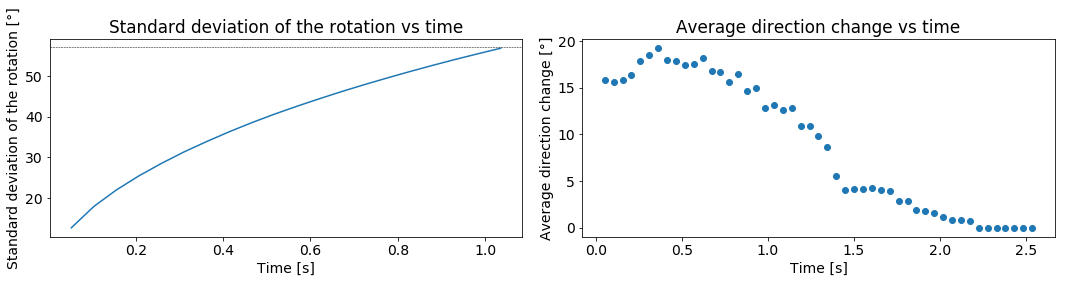

Boundary hits =  126  max length =  44
reorientation time =  1.09  s
average direction change every step =  15.82  °
average direction change in 1 s =  12.81  °


In [8]:
iwave = [];pathwave = []; startpoint = []; endpoints = []
count = 0; value = 0.9; check = 1; countpoint = 0; countlength=0; countlengthmax=0; remend=0
for i in range(maxlength):
    if i>oldstartpoint[countpoint] and i<oldendpoint[countpoint]:
        if particles[i,0,2] > value:
            if check == 1:
                startpoint.append(i)
                if remend != 0: endpoints.append(remend)                               
            check = 0
            iwave.append(i)
            pathwave.append(count)
            countlength += 1
            remend = i
        else: 
            if check == 0:
                check = 1
                count += 1
                if countlength > countlengthmax: countmaxlength = countlength
                countlength = 0
    else:
        if countpoint+1 < len(oldstartpoint):
            if i>oldstartpoint[countpoint+1]:
                check = 1
                countpoint += 1
                count +=1
                if countlength > countlengthmax: countmaxlength = countlength
                countlength = 0
                i -= 1
if len(endpoints) != 0: 
    if endpoints[-1] != remend: endpoints.append(remend)
else: endpoints.append(shortlength)
    
pathnumber = len(startpoint)
pathlength = np.zeros(pathnumber)
for i in range(pathnumber): pathlength[i] = int(endpoints[i]-startpoint[i])
maxpathlength = int(max(pathlength))
straightpaths = np.zeros((maxpathlength,pathnumber))
for i in range(len(startpoint)): straightpaths[:endpoints[i]-startpoint[i],i] = newmoveangle[startpoint[i]:endpoints[i]]

for i in range(pathnumber):
    check = 0 
    while check == 0:
        if straightpaths[0,i] > 360: straightpaths[:int(pathlength[i]),i] -= 360
        if straightpaths[0,i] < 0: straightpaths[:int(pathlength[i]),i] += 360
        if straightpaths[0,i] >= 0 and straightpaths[0,i] <= 360: check = 1
    
datatau = np.zeros((maxpathlength,pathnumber))
for k in range(pathnumber):
    for i in range(int(pathlength[k]-1)):
        test = True; j = i+1
        while test == True:
            diff = abs(straightpaths[i,k]-straightpaths[j,k])
            if diff > 57.3:
                test = False
                datatau[i,k] = (j-i)*dt
            if j+2 > pathlength[k]:           
                datatau[i,k] = np.nan
                test = False
            j += 1
lengthangle = 50
anglechange = np.zeros((pathnumber,lengthangle))
meananglechange = np.zeros(lengthangle)
for m in range(1,lengthangle):
    delta = m
    for k in range(pathnumber):
        count = 0; diff = 0
        for i in range(int(pathlength[k]-1)-delta):
            anglediff = abs(straightpaths[i,k]-straightpaths[i+delta,k])
            if anglediff == anglediff and anglediff != 0:
                diff += anglediff
                count += 1
        if count != 0: anglechange[k,m] = diff/count
    meananglechange[m] = np.mean(anglechange[:,m])
meanchange = meananglechange[1]
    
newangle2 = np.zeros(maxlength); pseudomoveangle = np.zeros(maxlength); pseudoangle = np.zeros(maxlength)
newangle2[:] = newangle[:]
pseudomoveangle[:] = newmoveangle[:]
for i in range(len(tendx)):  
    newangle2[int(tendx[i]/dt):] -= newangle2[int(tendx[i]/dt)]-newangle2[int(tendx[i]/dt-1)]
    if i < len(tendx)-1:
        pseudomoveangle[int(tendx[i]/dt):] += (pseudomoveangle[int(tendx[i]/dt)+1] - pseudomoveangle[int(tendx[i]/dt)+2])
newangledr = np.zeros(maxlength); newangledr2 = np.zeros(maxlength)
for i in range(1,maxlength):
    newangledr[i] = abs(newangle[i]-newangle[i-1])
    newangledr2[i] = abs(newangle2[i]-newangle2[i-1])
for i in range(maxlength):
    if newangledr2[i] > 100: newangle2[i:] -= newangle2[i]-newangle2[i-1]        
check = True; i = 1
reorwave= np.zeros((maxlength,2))
while check == True:
    diff = np.zeros(maxlength-i)
    for j in range(i,maxlength): diff[j-i] = newangle2[j] - newangle2[j-i]
    std = np.std(diff)
    reorwave[i,0] = i*dt
    reorwave[i,1] = std
    if std/57.3 >= 1: 
        check = False
        reorlen = i
    else: i += 1 
reorientationtime = i*dt 
pseudoangle = newangle2

#fig=plt.figure(1, figsize = (15,4) )
#for i in range(pathnumber): plt.plot(timewave[:int(pathlength[i])],straightpaths[:int(pathlength[i]),i])
#plt.title('Direction of the movement for movements between boundary hits with v > 0.9 $\cdot$ v$_{max}$')
#plt.xlabel('Time [s]')
#plt.ylabel('Angle of the motion [°]')
#plt.tight_layout() 
#plt.savefig('Angle over times'+str(printnum)+'.pdf', format='pdf')
#plt.show()

fig=plt.figure(1, figsize = (15,4) )
plt.subplot(1,2,1)
plt.plot(reorwave[1:reorlen,0],reorwave[1:reorlen,1])
plt.title('Standard deviation of the rotation vs time')
plt.xlabel('Time [s]')
plt.ylabel('Standard deviation of the rotation [°]')
plt.axhline(y=57.3,linewidth=0.5, color = 'k',linestyle='--')
    
lin = np.linspace(1,lengthangle-1,lengthangle-1)
plt.subplot(1,2,2)
plt.scatter(lin*dt,meananglechange[1:])
plt.title('Average direction change vs time')
plt.xlabel('Time [s]')
plt.ylabel('Average direction change [°]')
plt.tight_layout() 
plt.savefig('Reorientation time'+str(printnum)+'.pdf', format='pdf')
plt.show() 

print('Boundary hits = ',pathnumber,' max length = ',maxpathlength)
print('reorientation time = ',round(reorientationtime,2),' s')
print('average direction change every step = ',round(meanchange,2),' °')
anglesecond = meananglechange[int(1/dt)]
print('average direction change in 1 s = ',round(anglesecond,2),' °')

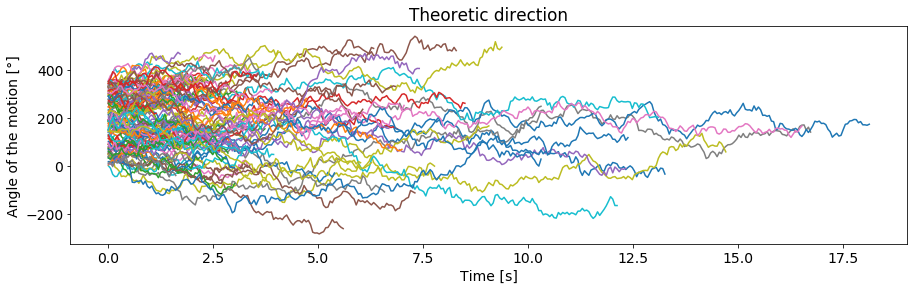

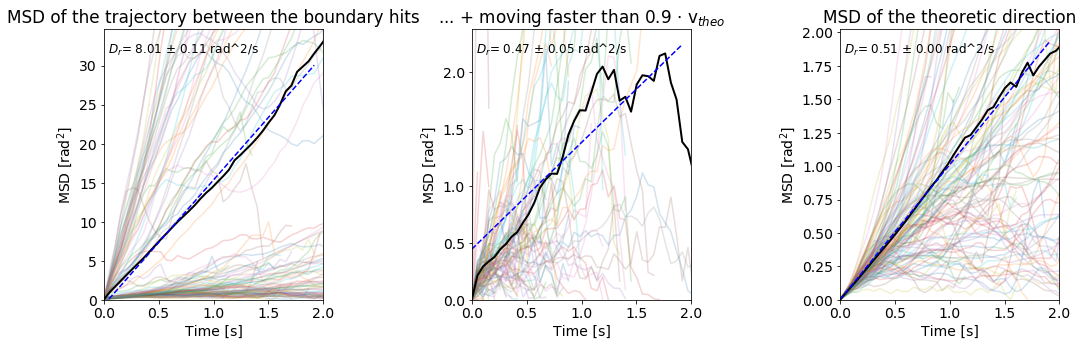

all trajectories: D_rot =  8.01  +-  0.11  rad^2/s
v > 0.9:          D_rot =  0.47  +-  0.05  rad^2/s
theory:           D_rot =  0.51  +-  0.0  rad^2/s


In [9]:
oldMSD = np.zeros((oldmaxpathlength,oldpathnumber));MSD = np.zeros((maxpathlength,pathnumber))
oldMSDmean = np.zeros((oldmaxpathlength,2));MSDmean = np.zeros((maxpathlength,2))

for i in range(oldpathnumber):     #MSD for the moving direction between boundary hits
    length = int(oldpathlength[i])
    result = msd_1d(oldstraightpaths[:length,i]*2*np.pi/360)
    oldMSD[:length,i] = result
    oldMSDmean[:,0] += oldMSD[:,i]
    oldMSDmean[:length,1] += 1
    if oldMSDmean[1,0] != oldMSDmean[1,0]: print('What? at path = ',i)
oldMSDmean[:,0] /= oldMSDmean[:,1]  
for i in range(oldpathnumber):
    for j in range(1,oldmaxpathlength):
        if oldMSD[j,i] == 0: oldMSD[j,i] = np.nan

for i in range(pathnumber):        #MSD for the moving direction between boundary hits with v > 0.9 * v_max
    length = int(pathlength[i])
    result = msd_1d(straightpaths[:length,i]*2*np.pi/360)
    MSD[:length,i] = result
    MSDmean[:,0] += MSD[:,i]
    MSDmean[:length,1] += 1
MSDmean[:,0] /= MSDmean[:,1]  
for i in range(pathnumber):
    for j in range(1,maxpathlength):
        if MSD[j,i] == 0: MSD[j,i] = np.nan
        
angleMSD = np.zeros((oldmaxpathlength,oldpathnumber))
angleMSDmean = np.zeros((oldmaxpathlength,2))
for i in range(1,oldpathnumber):
    length = int(oldpathlength[i])
    result = msd_1d(anglestraightpaths[:length,i]*2*np.pi/360)
    angleMSD[:length,i] = result
    if len(result) > 0:
        if result[-1] == result[-1]:
            angleMSDmean[:,0] += angleMSD[:,i]
            angleMSDmean[:length,1] += 1
angleMSDmean[:,0] /= angleMSDmean[:,1]  
for i in range(oldpathnumber):
    for j in range(1,oldmaxpathlength):
        if angleMSD[j,i] == 0: angleMSD[j,i] = np.nan

fig=plt.figure(1, figsize = (15,4) )#Plotting
for i in range(1,oldpathnumber): plt.plot(timewave[:int(oldpathlength[i])],anglestraightpaths[:int(oldpathlength[i]),i])
plt.title('Theoretic direction')
plt.xlabel('Time [s]')
plt.ylabel('Angle of the motion [°]')
plt.show()

tlim = 2                              
fig=plt.figure(1, figsize = (15,5) )
plt.subplot(1,3,1)
for i in range(oldpathnumber): 
    length = int(oldpathlength[i])
    plt.plot(timewave[:length],oldMSD[:length,i],alpha = 0.2)
plt.plot(timewave[:oldmaxpathlength],oldMSDmean[:oldmaxpathlength,0],c='k',linewidth=2)
tlim1 = min(tlim,(oldmaxpathlength-1)*dt)
fitlength = int(tlim1/dt)
popt,pcov = curve_fit(linMSD2, timewave[:fitlength], oldMSDmean[:fitlength,0],p0 = (2,0))
pErr = np.sqrt(np.diag(pcov))
plt.plot(timewave[:fitlength],linMSD2(timewave[:fitlength],*popt),linestyle='--',c='b',linewidth=1.5)
plt.xlabel('Time [s]')
plt.ylabel('MSD [rad$^2$]')
plt.xlim([0,tlim1])
plt.ylim([0,1.1*max(oldMSDmean[:int(tlim1/dt),0])])
plt.title('MSD of the trajectory between the boundary hits')
val1 = popt[0]; valerr1 = pErr[0]
plt.text(0.02*tlim1,max(oldMSDmean[:int(tlim1/dt),0]),'$D_r$= {:.2f} $\pm$ {:.2f} rad^2/s'.format(val1/2,valerr1/2),fontsize=12)

plt.subplot(1,3,2)
for i in range(pathnumber): 
    length = int(pathlength[i])
    plt.plot(timewave[:length],MSD[:length,i],alpha = 0.2)
plt.plot(timewave[:maxpathlength],MSDmean[:maxpathlength,0],c='k',linewidth=2)
tlim2 = min(2,(maxpathlength-1)*dt)
fitlength = int(tlim2/dt)
popt,pcov = curve_fit(linMSD2, timewave[5:fitlength], MSDmean[5:fitlength,0],p0 = (2,0))
pErr = np.sqrt(np.diag(pcov))
plt.plot(timewave[:fitlength],linMSD2(timewave[:fitlength],*popt),linestyle='--',c='b',linewidth=1.5)
plt.xlabel('Time [s]')
plt.ylabel('MSD [rad$^2$]')
plt.xlim([0,tlim2])
plt.ylim([0,1.1*max(MSDmean[:int(tlim2/dt),0])])
plt.title('... + moving faster than 0.9 $\cdot$ v$_{theo}$')
val2 = popt[0]; valerr2 = pErr[0]
Drotexp = val2/2; Drotexperr = valerr2/2
plt.text(0.02*tlim2,max(MSDmean[:int(tlim2/dt),0]),'$D_r$= {:.2f} $\pm$ {:.2f} rad^2/s'.format(val2/2,valerr2/2),fontsize=12)

plt.subplot(1,3,3)
for i in range(oldpathnumber):
    length = int(oldpathlength[i])
    plt.plot(timewave[:length],angleMSD[:length,i],alpha = 0.2)
plt.plot(timewave[:oldmaxpathlength],angleMSDmean[:oldmaxpathlength,0],c='k',linewidth=2)
tlim3 = min(tlim,(oldmaxpathlength-1)*dt)
fitlength = int(tlim3/dt)
with warnings.catch_warnings():
    warnings.simplefilter("error", OptimizeWarning)
    try:
        popt,pcov = curve_fit(linMSD, timewave[:fitlength], angleMSDmean[:fitlength,0],p0 = (2))
        pErr = np.sqrt(np.diag(pcov))
        plt.plot(timewave[:fitlength],linMSD(timewave[:fitlength],*popt),linestyle='--',c='b',linewidth=1.5)
        val3 = popt[0]; valerr3 = pErr[0]
        plt.text(0.02*tlim3,max(angleMSDmean[:int(tlim3/dt),0]),'$D_r$= {:.2f} $\pm$ {:.2f} rad^2/s'.format(val3/2,valerr3/2),fontsize=12)
    except OptimizeWarning:
        plt.text(fitlength*dt/3,0,'Failed fitting!',fontsize=16)
        val3 = 666; valerr3 = 666
plt.xlabel('Time [s]')
plt.ylabel('MSD [rad$^2$]')
plt.xlim([0,tlim3])
plt.ylim([0,max(1.1*np.nanmax(angleMSDmean[:int(tlim3/dt),0]),1)])
plt.title('MSD of the theoretic direction')
Drot = val3/2; Droterr = valerr3/2
plt.tight_layout() 
plt.savefig('MSDangle'+str(printnum)+'.pdf', format='pdf')
plt.show()

print('all trajectories: D_rot = ',round(val1/2,2),' +- ',round(valerr1/2,2),' rad^2/s')
print('v > 0.9:          D_rot = ',round(val2/2,2),' +- ',round(valerr2/2,2),' rad^2/s')
print('theory:           D_rot = ',round(val3/2,2),' +- ',round(valerr3/2,2),' rad^2/s')

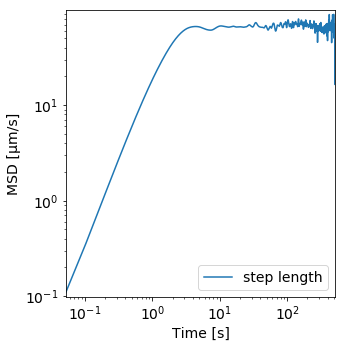

In [10]:
    result3 = msd_2d(particlesdisplay[:,0,0],particlesdisplay[:,0,1])
    plotlength = maxlength
    plotlength2 = maxlength*dt
    fig=plt.figure(1, figsize = (5,5) )
    plt.loglog(timewave,result3,label='step length')
    plt.xlabel('Time [s]')
    plt.ylabel('MSD [µm/s]')    
    plt.xlim([dt,plotlength2])
    plt.ylim([0.9*min(result3[1:plotlength]),1.1*max(result3[:plotlength])])
    plt.legend()
    plt.tight_layout()
    plt.savefig('MSDmy'+str(number)+'.pdf', format='pdf')
    plt.show() 

i =  100 / 289
i =  200 / 289
--- 45.49 seconds ---


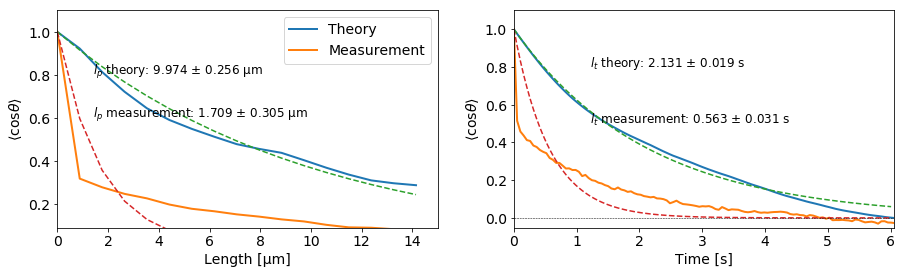

persistence length =  9.97  µm


NameError: name 'meanvelocity' is not defined

In [26]:
traveldistance = np.zeros(maxlength)
for i in range(1,maxlength):
    dx = (particlesdisplay[i,0,0]-particlesdisplay[i-1,0,0])*1e-6
    dy = (particlesdisplay[i,0,1]-particlesdisplay[i-1,0,1])*1e-6
    diff = np.sqrt(pow(dx,2)+pow(dy,2))
    traveldistance[i] = traveldistance[i-1] + diff
traveldistance *= 1e6
plength = 666; plengtherr = 666
plotlength = 15
checksteps = int(plotlength/dt)
start_time = time.time() 
meanstepsize = 5*np.mean(stepsize)
size = int(plotlength/meanstepsize+1)
lengthwave = np.zeros(size)
for i in range(size): lengthwave[i] = meanstepsize*i
ACFl = np.zeros((size,2))
countcorr = np.zeros(size)
corr = np.zeros((50*maxlength,size,2))
for i in range(1,checksteps):
    if (i+1) % 100 == 0: print('i = ',i+1,'/',checksteps)
    for m in range(i,maxlength):
        val = np.cos((pseudoangle[m]-pseudoangle[m-i])*np.pi/180)   #Theory
        valr = np.cos((pseudomoveangle[m]-pseudomoveangle[m-i])*np.pi/180)   #Real motion
        val2 = traveldistance[m] - traveldistance[m-i]
        check = True; k = 1
        while check == True:
            if val2 <= lengthwave[k] and val2 >= lengthwave[k-1]:
                corr[int(countcorr[k]),k,0] = val
                corr[int(countcorr[k]),k,1] = valr
                countcorr[k] += 1
                check = False
            else: k += 1
            if k == size: check = False
for i in range(size):
    if countcorr[i] != 0: 
        ACFl[i,0] = np.average(corr[:int(countcorr[i]),i,0])
        ACFl[i,1] = np.average(corr[:int(countcorr[i]),i,1])
ACFl[0,:] = 1
print("--- %s seconds ---" % round((time.time() - start_time),2))

check = 0; count = 0
while check == 0:
    if ACFl[count,0] < 0: check = 1
    else:    
        count += 1
        if count >= size: check = 1            
fitlength = int(min(count,size))

ACFt = np.zeros((maxlength,2))
ACFt[:,0] = acfangle_1d(pseudoangle)
ACFt[:,1] = acfangle_1d(pseudomoveangle)
check = 0; count2 = 0
while check == 0:
    if ACFt[count2,0] < 0: check = 1
    else:    
        count2 += 1
        if count2 >= maxlength: check = 1            
fitlength2 = int(min(count2,maxlength))

fig=plt.figure(1, figsize = (15,4) )
plt.subplot(1,2,1)
plt.plot(lengthwave,ACFl[:,0],linewidth = 2,label = 'Theory')    
plt.plot(lengthwave,ACFl[:,1],linewidth = 2,label = 'Measurement')
with warnings.catch_warnings():
    warnings.simplefilter("error", OptimizeWarning)
    try:
        popt,pcov = curve_fit(expfun, lengthwave[:fitlength], ACFl[:fitlength,0],p0 = (1))
        pErr = np.sqrt(np.diag(pcov))
        plength = popt[0]; plengtherr = pErr[0]
        if plengtherr < 2: 
            plt.text(0.1*lengthwave[-1],0.8,'$l_p$ theory: {:.3f} $\pm$ {:.3f} µm'.format(plength,plengtherr),fontsize=12)
            plt.plot(lengthwave[:fitlength],expfun(lengthwave[:fitlength],*popt),linestyle='--',linewidth=1.5)
        else:
            plt.text(fitlength*dt/3,0.8,'Failed fitting!',fontsize=16)
            plength = 666; plengtherr = 666
    except OptimizeWarning:
        plt.text(fitlength*dt/3,0.8,'Failed fitting!',fontsize=16)
        plength = 666; plengtherr = 666  
with warnings.catch_warnings():
    warnings.simplefilter("error", OptimizeWarning)
    try:
        popt,pcov = curve_fit(expfun, lengthwave[:fitlength], ACFl[:fitlength,1],p0 = (1))
        pErr = np.sqrt(np.diag(pcov))
        plength2 = popt[0]; plengtherr2 = pErr[0]
        if plengtherr < 2: 
            plt.text(0.1*lengthwave[-1],0.6,'$l_p$ measurement: {:.3f} $\pm$ {:.3f} µm'.format(plength2,plengtherr2),fontsize=12)
            plt.plot(lengthwave[:fitlength],expfun(lengthwave[:fitlength],*popt),linestyle='--',linewidth=1.5)
        else:
            plt.text(fitlength*dt/3,0.6,'Failed fitting!',fontsize=16)
            plength2 = 666; plengtherr2 = 666
    except OptimizeWarning:
        plt.text(fitlength*dt/3,0.6,'Failed fitting!',fontsize=16)
        plength2 = 666; plengtherr2 = 666
plt.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')  
plt.xlim([0,min(2*count*meanstepsize,min(max(totallength),plotlength))])
plt.ylim([1.2*min(min(ACFl[:,0]),min(ACFl[:,1])),1.1])
plt.xlabel('Length [µm]')
plt.ylabel(r'$\left \langle \cos \theta  \right \rangle$')
plt.legend()

plt.subplot(1,2,2)
plt.plot(timewave,ACFt[:,0],linewidth = 2,label = 'Theory')
plt.plot(timewave,ACFt[:,1],linewidth = 2,label = 'Measurement')
with warnings.catch_warnings():
    warnings.simplefilter("error", OptimizeWarning)
    try:
        popt,pcov = curve_fit(expfun, timewave[:fitlength2], ACFt[:fitlength2,0],p0 = (1))
        pErr = np.sqrt(np.diag(pcov))
        plt.plot(timewave[:fitlength2],expfun(timewave[:fitlength2],*popt),linestyle='--',linewidth=1.5)
        ptime = popt[0]; ptimeerr = pErr[0]
        plt.text(0.1*min(2*count2*dt,oldmaxpathlength*dt),0.8,'$l_t$ theory: {:.3f} $\pm$ {:.3f} s'.format(ptime,ptimeerr,2),fontsize=12)
    except OptimizeWarning:
        plt.text(fitlength2*dt/3,0.8,'Failed fitting!',fontsize=16)
        ptime = 666; ptimeerr = 666    
with warnings.catch_warnings():
    warnings.simplefilter("error", OptimizeWarning)
    try:
        popt,pcov = curve_fit(expfun, timewave[:fitlength2], ACFt[:fitlength2,1],p0 = (1))
        pErr = np.sqrt(np.diag(pcov))
        plt.plot(timewave[:fitlength2],expfun(timewave[:fitlength2],*popt),linestyle='--',linewidth=1.5)
        ptime2 = popt[0]; ptimeerr2 = pErr[0]
        plt.text(0.1*min(2*count2*dt,oldmaxpathlength*dt),0.5,'$l_t$ measurement: {:.3f} $\pm$ {:.3f} s'.format(ptime2,ptimeerr2,2),fontsize=12)
    except OptimizeWarning:
        plt.text(fitlength2*dt/3,0.6,'Failed fitting!',fontsize=16)
        ptime2= 666; ptimeerr2 = 666   
plt.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
plt.xlim([0,min(count2*dt,oldmaxpathlength*dt)])
plt.ylim([1.2*min(min(ACFt[:2*count2,0]),min(ACFt[:2*count2,1])),1.1])
plt.xlabel('Time [s]')
plt.ylabel(r'$\left \langle \cos \theta  \right \rangle$')
plt.savefig('ACFs'+str(printnum)+'.pdf', format='pdf')
plt.show()

print('persistence length = ',round(plength,2),' µm')
print('v / D_R            = ',round(meanvelocity/Drot,2),' µm')
print('v * tau_R          = ',round(meanvelocity*ptime,2),' µm')

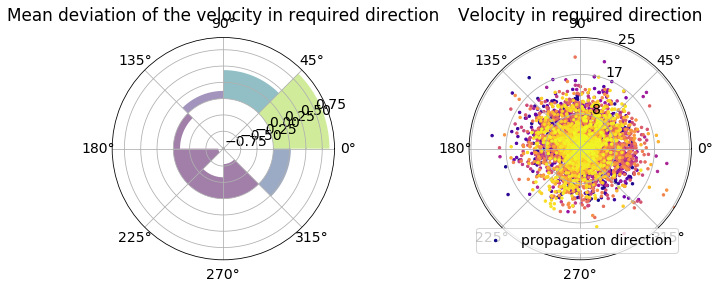

Angle =   [ 45.  90. 135. 180. 225. 270. 315. 360.]
Offset =  [0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7]
Counts =  [1069. 1144. 1354. 1437. 1151. 1251. 1157. 1437.]


In [11]:
distlaser = np.zeros(maxlength)
parts = 8
distangle = np.zeros((parts,4))     #0 - angle, 1 - distlaser, 2 - counts, 3 - velocity
for i in range(parts): distangle[i,0] = (i+1)/parts * 360
for i in range(maxlength):                        #Statistic over the laser offset (and the velocity in required direction) vs the required direction
    distlaser[i] = np.sqrt(pow(particles[i,0,4]-particles[i,0,0],2)+pow(particles[i,0,5]-particles[i,0,1],2))
    if abs(distlaser[i]-offset*pxtomum) > 1.5:
        #print('To high laser offset, t = ',round(i*dt,2),' s - dist = ',round(abs(distlaser[i]-offset),1),' µm')
        distlaser[i] = distlaser[i-1]
    if laserangle[i]<distangle[0,0]:
        distangle[0,1] += distlaser[i]
        distangle[0,2] += 1
        distangle[0,3] += velocity[i]
    else:
        for j in range(1,parts):
            if laserangle[i] > distangle[j-1,0] and laserangle[i] < distangle[j,0]:
                distangle[j,1] += distlaser[i]
                distangle[j,2] += 1
                distangle[j,3] += velocity[i]
distangle[:,1] /= distangle[:,2]
distangle[:,3] /= distangle[:,2]
timewave = np.linspace(0,maxlength*dt,maxlength,endpoint=False)

fig=plt.figure(1, figsize = (10,5) )
theta = np.linspace(0, 2 * np.pi, parts, endpoint=False)
radii = distangle[:,3] - np.mean(velocity)
width = 2*np.pi / (parts)
theta += width/2
ax = plt.subplot(121, projection='polar')
ax.set(aspect="equal",title='Mean deviation of the velocity in required direction')
bars = ax.bar(theta, radii, width=width, bottom=0.0)
for r, bar in zip(radii, bars):
    bar.set_facecolor(plt.cm.viridis(r))
    bar.set_alpha(0.5)
r = velocity
theta = particles[:,0,3]*np.pi/180
colorwave = cm.plasma(np.linspace(0, 1, maxlength))
ax =plt.subplot(1,2, 2, projection='polar')
plt.title('Velocity in required direction')
ax.scatter(theta, r,s=6,label='propagation direction',color=colorwave[:])
#ax.scatter(theta2, r,s=2,label='required direction')
ax.set_rmax(max(velocity))
ax.set_rticks([round(max(velocity)/3,0), round(2*max(velocity)/3,0), round(max(velocity))])
ax.set_rlabel_position(70)
ax.grid(True)
plt.legend()
plt.tight_layout() 
plt.savefig('Velocity angle'+str(printnum)+'.pdf', format='pdf')
plt.show()

showoffset=[];showoffset = distangle[:,1]
for i in range(parts):
    showoffset[i]=round(showoffset[i],1)
print('Angle =  ',distangle[:,0])
print('Offset = ',showoffset)
print('Counts = ',distangle[:,2])

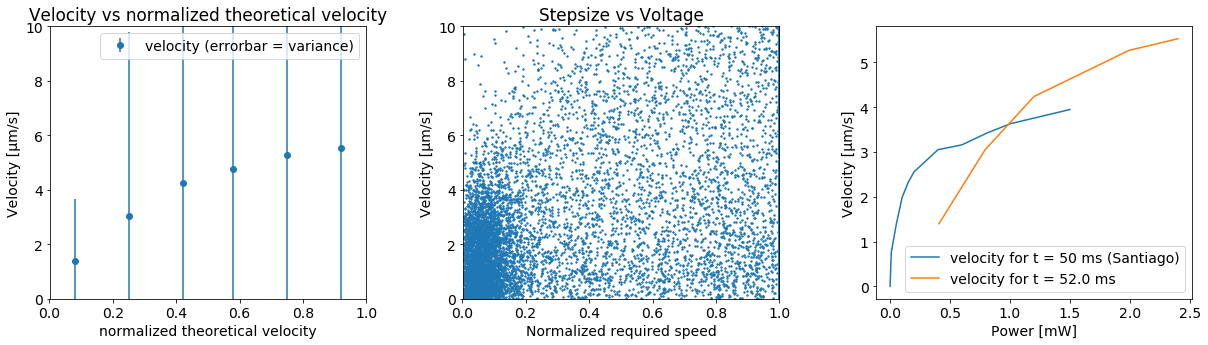

voltage =  [0.17 0.33 0.5  0.67 0.83 1.  ]
speed =    [1.4  3.05 4.24 4.77 5.27 5.53]
counts =   [4251.  878.  800.  772.  893.  994.]
max velocity =  5.53


In [12]:
value = particles[:,0,2]
steps2 = 6
speedhisto= np.zeros((steps2,4))    #0 - angle, 1 - velocity, 2 - counts, 3 - variance
speedcollect=np.zeros((steps2,maxlength))
for i in range(steps2): speedhisto[i,0] = min(value)+(i+1)/steps2*(1-min(value))
for i in range(maxlength):                      #Statistics over the velocity in required direction vs the theoretical velocity
    if value[i] < speedhisto[0,0]:
        speedhisto[0,1] += realvelocity[i]
        speedcollect[0,int(speedhisto[0,2])] = velocity[i]
        speedhisto[0,2] += 1
    else:
        for j in range(1,steps2):
            if value[i] > speedhisto[j-1,0] and value[i] < speedhisto[j,0]:
                speedhisto[j,1] += realvelocity[i]
                speedcollect[j,int(speedhisto[j,2])] = velocity[i]
                speedhisto[j,2] += 1
speedhisto[:,1] /= speedhisto[:,2]
for i in range(maxlength):
    for j in range(steps2):
        if speedcollect[j,i] == 0: speedcollect[j,i] = np.nan
valueprint = np.zeros(steps2);veloprint = np.zeros(steps2); plotvaluehisto = np.zeros(steps2)
for i in range(steps2):                          #Convert into a printable value
    valueprint[i] = round(speedhisto[i,0],2)
    veloprint[i] = round(speedhisto[i,1],2)
    plotvaluehisto[i] = round(speedhisto[i,0]-(1-min(value))/(2*steps2),2)
    speedhisto[i,3] = nanvar(speedcollect[i,:])  
data = []
for i in range(steps2): data.append(speedcollect[i,:int(speedhisto[i,2])])

folder2 = '/Users/alex/Documents/Projects/Santiago speed'
power = np.loadtxt(r''+str(folder2)+'/power.txt')
speed = np.loadtxt(r''+str(folder2)+'/v_paralel_50ms.txt')
    
fig, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(17, 5), sharey=True)
ax = plt.subplot(1, 3, 1)
plt.errorbar(plotvaluehisto[:], speedhisto[:,1],yerr=speedhisto[:,3], fmt='o',label='velocity (errorbar = variance)') #(errorbar = variance/sqrt(N))
plt.title('Velocity vs normalized theoretical velocity')
plt.xlabel('normalized theoretical velocity')
plt.ylabel('Velocity [µm/s]')
plt.ylim([0,min(max(velocity),10)])
plt.xlim([0.9*min(value),1])
plt.legend()
ax = plt.subplot(1, 3, 2)
plt.title('Stepsize vs Voltage')
plt.xlabel('Normalized required speed')
plt.ylabel('Velocity [µm/s]')
plt.scatter(value,velocity, s=2)
plt.ylim([0,min(max(velocity),10)])
plt.xlim([0.9*min(value),1])
ax = plt.subplot(1, 3, 3)
plt.plot(power,speed,label='velocity for t = 50 ms (Santiago)')
plt.plot(maxpower*valueprint,veloprint,label='velocity for t = '+str(round(1000*dt,0))+' ms')
plt.xlabel('Power [mW]')
plt.ylabel('Velocity [µm/s]')
plt.legend()
plt.tight_layout() 
plt.savefig('Velocity vs Normalized required speed'+str(printnum)+'.pdf', format='pdf')
plt.show()
    
print('voltage = ',valueprint)
print('speed =   ',veloprint)
print('counts =  ',speedhisto[:,2])
maxvelocity = round(speedhisto[-1,1],2)
print('max velocity = ',maxvelocity)

In [13]:
fastlength = 0
for i in range(len(startpoint)): fastlength += endpoints[i]-startpoint[i]
stepsparallel = np.zeros(fastlength); stepsperpendicular = np.zeros(fastlength)
count = 0
testwave = np.zeros(maxlength)
for i in range(len(startpoint)):
    herelength = endpoints[i]-startpoint[i]
    stepsparallel[count:count+herelength] = stepsize[startpoint[i]:endpoints[i]] 
    count2 = 0
    for j in range(startpoint[i],endpoints[i]):
        a = directionvector[j-2,:]; b = movingvector[j,:]
        test = np.math.atan2(np.linalg.det([a,b]),np.dot(a,b))
        testwave[count+count2] = test
        stepsperpendicular[count+count2] = np.sqrt(pow(velocitywithdiffusion[j]*dt,2)-pow(stepsize[j],2))
        if test < 0: stepsperpendicular[count+count2] *= -1
        count2 += 1        
    count += herelength
meanstepparallel = np.mean(stepsparallel)

binnumber = 25
binnumber2 = 50
binsall = np.linspace(min(stepsparallel+stepsperpendicular),max(stepsparallel+stepsperpendicular),binnumber2)
binsparallel = np.linspace(min(stepsparallel),max(stepsparallel),binnumber)
binsparallel2 = np.linspace(min(stepsparallel),max(stepsparallel),10*binnumber)
binsperpendicular = np.linspace(min(stepsperpendicular),max(stepsperpendicular),binnumber)
binsperpendicular2 = np.linspace(min(stepsperpendicular),max(stepsperpendicular),10*binnumber)
binsparallelcenter = np.zeros(binnumber-1); binsperpendicularcenter = np.zeros(binnumber-1)
for i in range(binnumber-1):
    binsparallelcenter[i] = (binsparallel[i]+binsparallel[i+1])/2
    binsperpendicularcenter[i] = (binsperpendicular[i]+binsperpendicular[i+1])/2

D_0 = kB*T/(6*np.pi*eta*R)
sigma_omega_squared = 2*D_0*1e12*dt/(R*1e6)**2
sigma_yomega_squared = (1-np.exp(-2*sigma_omega_squared))/2
v_omega = np.exp(sigma_omega_squared/2)*maxvelocity
sigma_parallel_squared = (1-sigma_yomega_squared)*v_omega**2*dt**2-np.exp(-sigma_omega_squared)*v_omega**2*dt**2+2*D_0*1e12*dt
sigma_perpendicular_squared = sigma_yomega_squared*v_omega**2*dt**2+2*(D_0*1e12)*dt
print('THEORY')
print('D_0 = ',round(D_0*1e12,3),' µm^2/s')
print('sigma_parallel = ',round(sigma_parallel_squared,4))
print('sigma_perpendicular = ',round(sigma_perpendicular_squared,4))
print('----------------')    
    
fig=plt.figure(1, figsize = (7,4) )
ax = plt.subplot(1,1,1)
histoparallel = np.histogram(stepsparallel,bins=binsparallel,density=1)
popt,pcov = curve_fit(fitparallel, binsparallelcenter, histoparallel[0],p0 = (D_0*1e12,meanstepparallel))
pErr = np.sqrt(np.diag(pcov))
plt.plot(binsparallel2,fitparallel(binsparallel2,*popt),linestyle='--',c='b',linewidth=1.5)
histoall = plt.hist(stepsparallel,bins=binsall,density=1,color='b',alpha=0.5,label=r'$\Delta r \cdot e_{\parallel }$')
D_0_parallel = popt[0]; D_0_parallel_err = pErr[0]
print('FROM PARALLEL')
print('fit D_0 = ',round(D_0_parallel,3),' +- ',round(D_0_parallel_err,3),'µm^2/s')
#plt.scatter(binsparallelcenter, histoparallel[0])
popt,pcov = curve_fit(gauss, binsparallelcenter, histoparallel[0],p0 = (sigma_parallel_squared,meanstepparallel))
pErr = np.sqrt(np.diag(pcov))
sigma_parallel_fit = popt[0]; sigma_parallel_fit_err = pErr[0]
#plt.plot(binsparallelcenter,gauss2(binsparallelcenter,*popt),linestyle='--',c='k',linewidth=1.5)
print('fit sigma_parallel = ',round(sigma_parallel_fit,4),' +- ',round(sigma_parallel_fit_err,4),' µm')
print('----------------')

histoperpendicular = np.histogram(stepsperpendicular,bins=binsperpendicular,density=1)
popt,pcov = curve_fit(fitperpendicular, binsperpendicularcenter, histoperpendicular[0],p0 = (D_0_parallel,0))
pErr = np.sqrt(np.diag(pcov))
plt.plot(binsperpendicular2,fitperpendicular(binsperpendicular2,*popt),linestyle='--',c='r',linewidth=1.5)
histoall = plt.hist(stepsperpendicular,bins=binsall,density=1,color='r',alpha=0.5,label=r'$\Delta r \cdot e_{\perp  }$')
D_0_perpendicular = popt[0]; D_0_perpendicular_err = pErr[0]
print('FROM PERPENDICULAR')
print('fit D_0 = ',round(D_0_perpendicular,3),' +- ',round(D_0_perpendicular_err,3),'µm^2/s')
popt,pcov = curve_fit(gauss, binsperpendicularcenter, histoperpendicular[0],p0 = (sigma_perpendicular_squared,0))
pErr = np.sqrt(np.diag(pcov))
sigma_perpendicular_fit = popt[0]; sigma_perpendicular_fit_err = pErr[0]
print('fit sigma_perpendicular = ',round(sigma_perpendicular_fit,4),' +- ',round(sigma_perpendicular_fit_err,4),' µm')

plt.xlabel('Step size [µm]')
plt.ylabel('Probability')
plt.legend()
plt.savefig('Stepdistribution.pdf', format='pdf')
plt.show()

NameError: name 'velocitywithdiffusion' is not defined

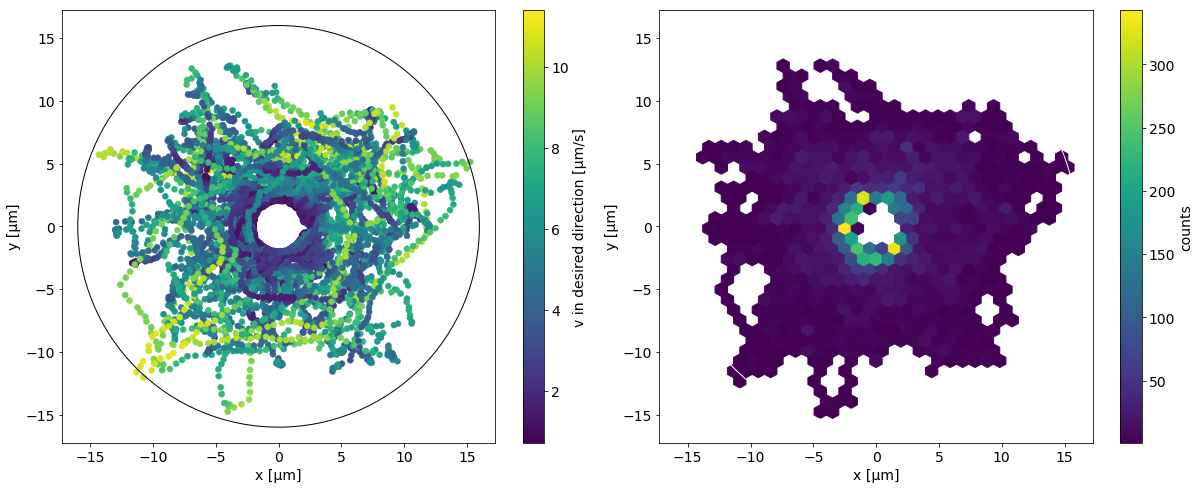

In [14]:
x = particles[:,0,0]
y = particles[:,0,1]
factor = 1.08
xmin = -factor*boundaryradius*pxtomum#x.min()
xmax = factor*boundaryradius*pxtomum#x.max()
ymin = -factor*boundaryradius*pxtomum#y.min()
ymax = factor*boundaryradius*pxtomum#y.max()
x = particlesdisplay[smoothvalue:maxlength-smoothvalue,0,0]
y = particlesdisplay[smoothvalue:maxlength-smoothvalue,0,1]
v = smoothit[smoothvalue:maxlength-smoothvalue]
gridsizevalue = 30
fig, axs = plt.subplots(ncols=2, figsize=(17,7), sharex='all')
fig.subplots_adjust(hspace=0.1, left=0.05, right=0.95)
ax = axs[0]
circle2 = plt.Circle((0, 0), boundaryradius*pxtomum, color='k', fill=False)
ax.add_artist(circle2)
im = ax.scatter(x,y,c=v,linewidths=0.5)
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
ax.tick_params(axis='y')
#plt.title('Particle position')
ax.axis('equal')
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
cb = fig.colorbar(im, ax=ax)
cb.set_label('v in desired direction [µm/s]')
x = particlesdisplay[:,0,0]
y = particlesdisplay[:,0,1]
#https://matplotlib.org/2.0.0/examples/pylab_examples/hexbin_demo.html
ax = axs[1]
hb = ax.hexbin(x, y, gridsize=gridsizevalue,mincnt=0.01)
ax.axis([xmin, xmax, ymin, ymax])
circle2 = plt.Circle((0, 0), boundaryradius*pxtomum, color='w', fill=False)
ax.add_artist(circle2)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
ax.axis('equal')
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
plt.tight_layout() 
plt.savefig('Path of the particle colored'+str(printnum)+'.pdf', format='pdf')
plt.savefig('Path of the particle colored'+str(printnum)+'.svg', format='svg')
plt.show()

In [16]:
boundaryradius*pxtomum

15.99

radius =    [ 3.   4.5  6.   7.6  9.1 10.6 12.2 13.7 15.2]  [µm]
drift =     [ 0.009 -0.106 -0.144  0.164  0.044  0.289  0.395  1.575  1.175]  [µm/s]
counts =    [4421. 1160. 1074. 1002.  661.  499.  296.  115.   28.]
velocity =  [2.08 4.5  5.4  5.22 6.59 5.85 6.09 6.06 8.19]  [µm/s]
counts/A =  [0.017 0.003 0.002 0.001 0.001 0.001 0.    0.    0.   ]  [1/(s*µm^2)]
------
v in     =  [2.27 5.08 5.67 5.07 6.81 6.16 6.59 5.94 8.57]  [µm/s]
count in =  [2086.  534.  542.  495.  320.  231.  132.   48.   10.]
v out    =  [1.92 4.01 5.13 5.36 6.39 5.59 5.69 6.15 7.98]  [µm/s]
count out=  [2335.  626.  532.  507.  341.  268.  164.   67.   18.]


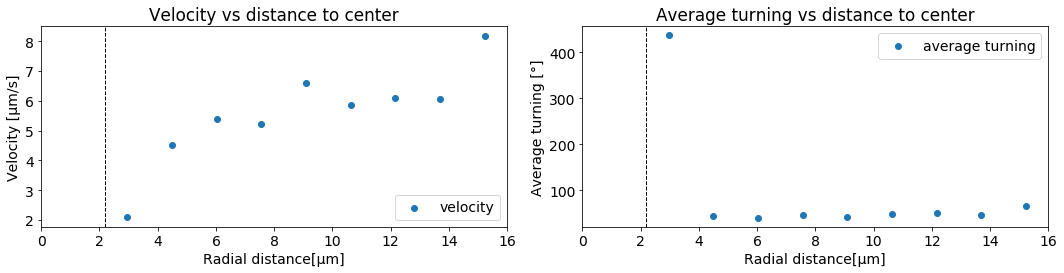

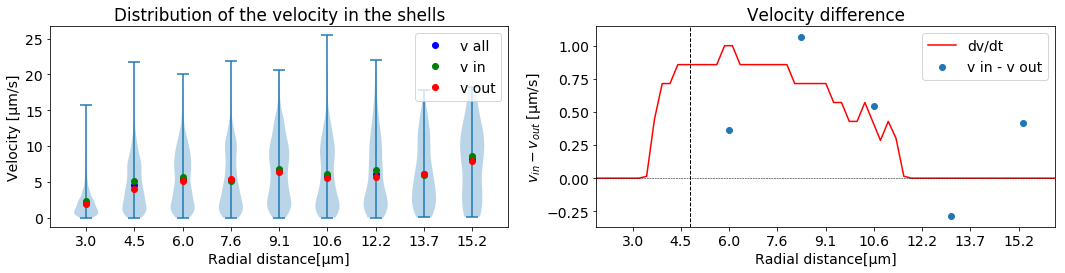

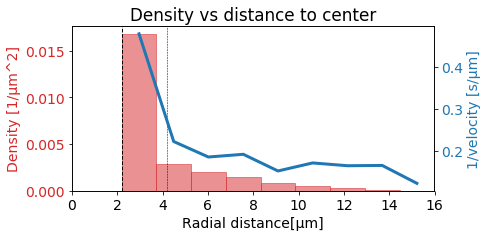

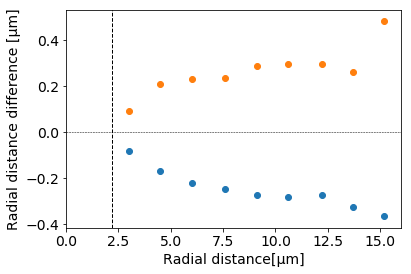

In [26]:
driftdelay = 1
steps = 10                             #Number of shells around the center
radialhist = np.zeros((steps,8))       #0 - radius, 1 - effective radial drift, 2 - counts
radialdistance = np.zeros(maxlength)   #3 - velocity, 4 - area, 5 - counts/(area*steps*dt), 6 - angle change, 7 - counts
radialvelo = np.zeros((steps,6))       #0 - c inwards, 1 - counts inwards, 2 - c outwards, 3 - counts outwards
base=(boundaryradius*pxtomum-2*R*1e6)/(steps-1)  #4 - v inwards, 5 - v outwards
for i in range(steps):
    radialhist[i,0] = 2*R*1e6+i*base
    if i>0: radialhist[i,4] = round(np.pi*(pow(radialhist[i,0],2)-pow(radialhist[i-1,0],2)),4)
plotdist = np.zeros(steps)
for i in range(steps): plotdist[i] = round(radialhist[i,0]-base/2,2)
plotdist[0] = np.nan
radialdistance[:] = np.sqrt(pow(particlesdisplay[:,0,0],2)+pow(particlesdisplay[:,0,1],2))
velocollect = np.zeros((maxlength,steps));driftcollect = np.zeros((maxlength,steps))
step = np.zeros(maxlength); shell = np.zeros(maxlength); inout = []
for i in range(max(driftdelay,2),maxlength):
    for j in range(steps):
        if radialdistance[i] < radialhist[j,0] and radialdistance[i] > radialhist[j-1,0]:
            radialdrift = radialdistance[i]-radialdistance[i-driftdelay]
            radialhist[j,1] += radialdrift
            velocollect[int(radialhist[j,2]),j] = velocity[i]
            driftcollect[int(radialhist[j,2]),j] = radialdistance[i]-radialdistance[i-driftdelay]
            radialhist[j,2] += 1
            radialhist[j,3] += velocity[i]
            step[i] = i; shell[i] = round(plotdist[j],2)
            if velocity[i] != velocity[i]: print('v NaN at i = ',i)
            if radialdrift < 0:
                radialvelo[j,0] += radialdrift
                radialvelo[j,4] += velocity[i]
                radialvelo[j,1] += 1
                inout.append('inwards')
            else:
                radialvelo[j,2] += radialdrift
                radialvelo[j,5] += velocity[i]
                radialvelo[j,3] += 1
                inout.append('outwards')
    if shell[i] == 0:
        step[i] = i; shell[i] = 888
        radialdrift = radialdistance[i]-radialdistance[i-driftdelay]
        if radialdrift < 0: inout.append('inwards')
        else: inout.append('outwards')
    j=steps-1
radialhist[1:,1] /= (radialhist[1:,2]*dt)
radialhist[1:,3] /= radialhist[1:,2]
totalcounts = sum(radialhist[1:,2])
radialhist[1:,5] = radialhist[1:,2]/(radialhist[1:,4]*totalcounts)
driftcollect[:,:] /= dt
radialvelo[1:,0] = radialvelo[1:,0]/(radialvelo[1:,1]*dt)
radialvelo[1:,2] = radialvelo[1:,2]/(radialvelo[1:,3]*dt)
radialvelo[1:,4] /= radialvelo[1:,1]
radialvelo[1:,5] /= radialvelo[1:,3]
remj = 888;anglechange = 0; shell2 = []; change = []; changewave = np.zeros((steps,2))
for i in range(1,maxlength):
    for j in range(steps):
        if radialdistance[i] < radialhist[j,0] and radialdistance[i] > radialhist[j-1,0]:
            if j != remj:
                if remj != 888:
                    shell2.append(remj)
                    change.append(abs(anglechange))
                    radialhist[remj,6] += abs(anglechange)
                    radialhist[remj,7] += 1
                remj = j
                anglechange = 0
            if j == remj:
                diff = np.zeros(3)
                diff[0] = moveangle[i]-moveangle[i-1]
                diff[1] = moveangle[i]+360-moveangle[i-1]
                diff[2] = moveangle[i]-360-moveangle[i-1]
                absmini = min(abs(diff))
                if absmini != abs(diff[0]):
                    if absmini == abs(diff[1]): mini = diff[1]
                    else: mini = diff[2]
                else: mini = diff[0]   
                anglechange += mini
radialhist[1:,6] /= radialhist[1:,7]
for i in range(maxlength):
    for j in range(steps):
        if velocollect[i,j] == 0:
            velocollect[i,j] = np.nan
            driftcollect[i,j] = np.nan
yerrvelo = np.zeros(steps); yerrdrift = np.zeros(steps)
for i in range(1,steps):
    if velocollect[0,i] == velocollect[0,i]:
        yerrvelo[i] = nanvar(velocollect[:int(radialhist[j,2]-1),i])
        yerrdrift[i] = nanvar(driftcollect[:int(radialhist[j,2]-1),i])
        if yerrvelo[i] != yerrvelo[i]:
            yerrvelo[i] = 0
            yerrdrift[i] = 0
total = sum(radialhist[1:,5])
meandensity = 0
for i in range(1,len(plotdist)): meandensity += radialhist[i,5]/total*plotdist[i]
vardensity = 0
for i in range(1,len(plotdist)): vardensity += radialhist[i,5]*pow(plotdist[i]-meandensity,2)/total
sddensity = np.sqrt(vardensity)
radiusprint = np.zeros(steps);driftprint = np.zeros(steps); velocityprint = np.zeros(steps); countsAprint = np.zeros(steps)
vin = np.zeros(steps);vout = np.zeros(steps)
for i in range(1,steps):
    radiusprint[i] = round(plotdist[i],1)
    driftprint[i] = round(radialhist[i,1],3)
    velocityprint[i] = round(radialhist[i,3],2)
    countsAprint[i] = round(radialhist[i,5],3)
    vin[i] = round(radialvelo[i,4],2)
    vout[i] = round(radialvelo[i,5],2)
print('radius =   ',radiusprint[1:],' [µm]')    
print('drift =    ',driftprint[1:], ' [µm/s]')
print('counts =   ',radialhist[1:,2])
print('velocity = ',velocityprint[1:], ' [µm/s]')
print('counts/A = ',countsAprint[1:], ' [1/(s*µm^2)]')
print('------')
print('v in     = ',vin[1:], ' [µm/s]')
print('count in = ',radialvelo[1:,1])
print('v out    = ',vout[1:], ' [µm/s]')
print('count out= ',radialvelo[1:,3])
vdiff = radialvelo[1:,4]-radialvelo[1:,5]
ddiff = -radialvelo[1:,0]-radialvelo[1:,2]
vdiffmax = max(vdiff)
for i in range(len(vdiff)):
    if vdiff[i] == vdiffmax: vdiffmaxdist = radiusprint[i-1]
ddiffmax = max(ddiff)
for i in range(len(vdiff)):
    if ddiff[i] == ddiffmax: ddiffmaxdist = radiusprint[i-1]  
total = sum(radialhist[1:,5])
meandensity = 0
for i in range(1,len(plotdist)): meandensity += radialhist[i,5]/total*plotdist[i]
back = int(delay)
pastmorein = np.zeros((maxlength,steps))
pastmoreout = np.zeros((maxlength,steps))
countmorein = np.zeros(steps)
countmoreout = np.zeros(steps)
for i in range(int(back),maxlength):
    for j in range(steps):
        if radialdistance[i] < radialhist[j,0] and radialdistance[i] > radialhist[j-1,0]:
            dist = radialdistance[i] - radialdistance[i-1]
            if dist > 0:
                dist = radialdistance[i] - radialdistance[i-back]
                pastmorein[int(countmorein[j]),j] = -dist
                countmorein[j] += 1
            else:
                dist = radialdistance[i] - radialdistance[i-back]
                pastmoreout[int(countmoreout[j]),j] = -dist
                countmoreout[j] += 1
for i in range(steps):
    pastmorein[int(countmorein[i]):,i] = np.nan
    pastmoreout[int(countmoreout[i]):,i] = np.nan
meanmorein = np.zeros(steps)
meanmoreout = np.zeros(steps)
for i in range(1,steps):
    meanmorein[i] = np.nanmean(pastmorein[:int(countmorein[i]),i])
    meanmoreout[i] = np.nanmean(pastmoreout[:int(countmoreout[i]),i])
mini = float(floor(np.nanmin(pastmorein)))
maxi = ceil(np.nanmax(pastmoreout))

length = boundaryradius
points = 100
distpx = np.linspace(0,length,points)
distmum = distpx * pxtomum
intensity = np.zeros(points)
intensity = 2*np.exp(-distpx**2/sigmavelo**2)/2
distint = np.linspace(0,1,points)
velocitysim = np.zeros(points)
for i in range(points):
    value = -5/4*distint[i]+9/8
    if value < 0: value = 0
    if value > 1: value = 1
    velocitysim[i] = value
velocitydist = np.zeros(points)
for i in range(points):
    check = True; count2 = 0
    while check == True:
        if distint[count2] >= intensity[i]:
            velocitydist[i] = velocitysim[count2]
            check = False
        else: count2 += 1

fig=plt.figure(1, figsize = (15,4) )
plt.subplot(1,2,1)
plt.scatter(plotdist[1:], radialhist[1:,3],label='velocity')
plt.xlabel('Radial distance[µm]')
plt.ylabel('Velocity [µm/s]')
plt.title('Velocity vs distance to center')
plt.axvline(x=2*R*1e6,linewidth=1, color = 'k',linestyle='--')
plt.xlim([0,boundaryradius*pxtomum])
plt.legend()

plt.subplot(1,2,2)
plt.scatter(plotdist[1:], radialhist[1:,6],label='average turning')
plt.xlabel('Radial distance[µm]')
plt.ylabel('Average turning [°]')
plt.title('Average turning vs distance to center')
plt.axvline(x=2*R*1e6,linewidth=1, color = 'k',linestyle='--')
plt.xlim([0,boundaryradius*pxtomum])
plt.legend()
plt.tight_layout() 
plt.savefig('Velocity and anglechange'+str(number)+'.pdf', format='pdf')
plt.show() 
#https://matplotlib.org/gallery/statistics/customized_violin.html
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))#, sharey=True
data = [sorted(velocollect[:int(radialhist[std,2]-1),std]) for std in range(1,steps)]
ax1.set_ylabel('Velocity [µm/s]')
ax1.set_xlabel('Radial distance[µm]')
ax1.set_title('Distribution of the velocity in the shells')
ax1.violinplot(data)
ax1.plot(radialhist[:,3], 'bo',label = 'v all')
ax1.plot(radialvelo[:,4], 'go',label = 'v in')
ax1.plot(radialvelo[:,5], 'ro',label = 'v out')
#ax1.axvline(x=2*R*1e6,linewidth=1, color = 'k',linestyle='--')
#ax1.set_xlim([0,boundaryradius*pxtomum])
ax1.legend()
diffv = np.gradient(velocitydist)*1e-6/(distmum[1]-distmum[0])
ax2.set_ylabel('$v_{in}-v_{out}$ [µm/s]')
ax2.set_xlabel('Radial distance[µm]')
ax2.set_title('Velocity difference')
ax2.scatter(radiusprint[1:],radialvelo[1:,4]-radialvelo[1:,5],label ='v in - v out')
ax2.plot(distmum,diffv/max(diffv),color='r',label = 'dv/dt')
ax2.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
ax2.axvline(x=2*R*1e6,linewidth=1, color = 'k',linestyle='--')
ax2.set_xlim([0,boundaryradius*pxtomum])
ax2.legend()
labels = radiusprint[1:]
for ax in [ax1,ax2]: set_axis_style(ax, labels)  
plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.tight_layout() 
plt.savefig('Velocity distribution'+str(number)+'.pdf', format='pdf')
plt.show()
#diffv = np.gradient(v)*1e-6/(dd[1]-dd[0])

fig=plt.figure(1, figsize = (7,3.5) )
ax1 = plt.subplot(1,1,1)
color = 'tab:red'
plt.title('Density vs distance to center')
ax1.set_xlabel('Radial distance[µm]')
ax1.set_ylabel('Density [1/µm^2]', color=color)
ax1.bar(plotdist[1:], radialhist[1:,5],base, color=color,alpha = 0.5, edgecolor = color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim([0,boundaryradius*pxtomum])
ax1.axvline(x=2*R*1e6,linewidth=1, color = 'k',linestyle='--')
ax1.axvline(x=meandensity,linewidth=0.5, color = 'k',linestyle='--',label = 'mean of rho(r)/r$^2$')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('1/velocity [s/µm]', color=color)  # we already handled the x-label with ax1
ax2.plot(plotdist[1:],1/radialhist[1:,3], color=color, linewidth = 3)
ax2.tick_params(axis='y', labelcolor=color)
plt.tight_layout() 
plt.savefig('Density'+str(number)+'.pdf', format='pdf')
plt.show()

fig=plt.figure(1, figsize = (6,4) )
plt.scatter(radiusprint[1:],meanmorein[1:])
plt.scatter(radiusprint[1:],meanmoreout[1:])
plt.axvline(x=2*R*1e6,linewidth=1, color = 'k',linestyle='--')
plt.xlim([0,boundaryradius*pxtomum])
plt.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
plt.xlabel('Radial distance[µm]')
plt.ylabel('Radial distance difference [µm]')
plt.savefig('Radial distance difference vs radial distance'+str(number)+'.pdf', format='pdf')
plt.show()

/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:74: RuntimeWarning: invalid value encountered in true_divide
/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:75: RuntimeWarning: invalid value encountered in true_divide
/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:76: RuntimeWarning: invalid value encountered in true_divide
/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:77: RuntimeWarning: invalid value encountered in true_divide


3117


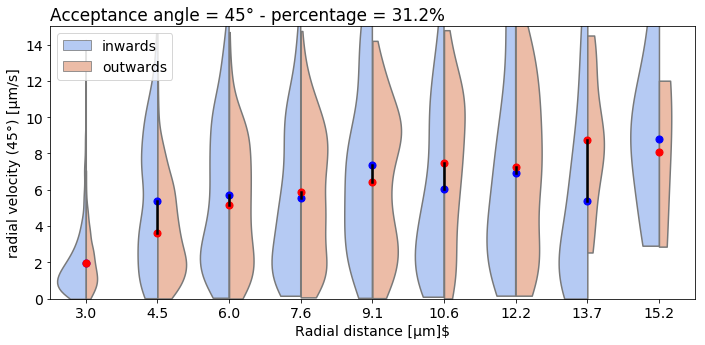

In [27]:
    driftdelay = 1   
    diffv = np.gradient(velocitydist)/(distmum[1]-distmum[0])
    maxpos = np.argmax(diffv)
    maxdist = distmum[maxpos]
    #radialdistance = distancetocenter
    
    radialdist = np.zeros((steps,3))       #0 - radius, 1 - effective radial drift, 2 - counts
    base=(boundaryradius*pxtomum-2*R*1e6)/(steps-1)  #4 - v inwards, 5 - v outwards
    for i in range(steps):
        radialdist[i,0] = 2*R*1e6+i*base
    for i in range(1, steps):
        radialdist[i,1] = round((radialdist[i,0]+radialdist[i-1,0])/2,1)
        radialdist[i,2] = round(radialdist[i,1]/maxdist,1)
      
    angletocenter = np.zeros(maxlength)
    for i in range(maxlength):
        a = [-np.cos((particles[i,0,3])*np.pi/180),-np.sin((particles[i,0,3])*np.pi/180)]
        b = [particlesdisplay[i,0,0],particlesdisplay[i,0,1]]
        angletocenter[i] = np.arccos(np.dot(a,b)/(vectorlength(a)*vectorlength(b)))*180/np.pi
     
    radialdrift = np.zeros(maxlength)
    radialstats = np.zeros((steps,5))   #0 - radial distance, 1 - counts inwards, 2 - drift inwards
                                         #3 - counts outwards, 4 - drift inwards  
    limitedradialstats = np.zeros((steps,5))   #0 - radial distance, 1 - counts inwards, 2 - drift inwards
                                         #3 - counts outwards, 4 - drift inwards
    radialstats[:,0] = limitedradialstats[:,0] = radialdist[:,1]     
    allradialdata = np.zeros((maxlength,5))      #0 - not used, 1 - shell, 2 - in or out, 3 - radial drift
                                                 #4 - angletocenter
    limitedradialdata = np.zeros((maxlength,5))  #0 - step, 1 - shell, 2 - in or out, 3 - radial drift
    
    checkangle = 45
    count = 0
    inouttest = []; limitedinout = []  
    point = max(driftdelay,2)
    for i in range(point,maxlength):
        for j in range(1,steps):
            if radialdistance[i] < radialdist[j,0] and radialdistance[i] > radialdist[j-1,0]:
                radialdrift[i] = (radialdistance[i]-radialdistance[i-driftdelay])/dt
                allradialdata[i,1] = radialdist[j,1]
                allradialdata[i,3] = abs(radialdrift[i])
                allradialdata[i,4] = angletocenter[i]
                if radialdrift[i] <= 0:
                    radialstats[j,1] += 1
                    radialstats[j,2] += abs(radialdrift[i])
                    inouttest.append('inwards')
                    allradialdata[i,2] = 0
                    if angletocenter[i] < checkangle:
                        limitedradialstats[j,1] += 1
                        limitedradialstats[j,2] += abs(radialdrift[i])
                        limitedradialdata[count,0] = i
                        limitedradialdata[count,1] = radialdist[j,1]
                        limitedradialdata[count,2] = 0
                        limitedradialdata[count,3] = abs(radialdrift[i])
                        limitedradialdata[i,4] = angletocenter[i]
                        limitedinout.append('inwards')
                        count += 1
                else:
                    radialstats[j,3] += 1
                    radialstats[j,4] += radialdrift[i]
                    allradialdata[i,2] = 1
                    inouttest.append('outwards')
                    if angletocenter[i] > 180 - checkangle:
                        limitedradialstats[j,3] += 1
                        limitedradialstats[j,4] += abs(radialdrift[i])
                        limitedradialdata[count,0] = i
                        limitedradialdata[count,1] = radialdist[j,1]
                        limitedradialdata[count,2] = 1
                        limitedradialdata[count,3] = abs(radialdrift[i])
                        limitedradialdata[i,4] = angletocenter[i]
                        limitedinout.append('outwards')
                        count += 1
                j=steps
        if allradialdata[i,1] == 0: allradialdata[i,2] = 888
    radialstats[:,2] /= radialstats[:,1]
    radialstats[:,4] /= radialstats[:,3]
    limitedradialstats[:,2] /= limitedradialstats[:,1]
    limitedradialstats[:,4] /= limitedradialstats[:,3]
    print(count)
    
    vin = np.zeros(steps);vout = np.zeros(steps); limitedvin = np.zeros(steps); limitedvout = np.zeros(steps)
    for i in range(1,steps):
        vin[i] = round(radialstats[i,2],2)
        vout[i] = round(radialstats[i,4],2)
        limitedvin[i] = round(limitedradialstats[i,2],2)
        limitedvout[i] = round(limitedradialstats[i,4],2)
        
    alldata1 = list(zip(arange(point,maxlength),allradialdata[point:,1],inouttest[point:],allradialdata[point:,3]))
    alldata2 = pd.DataFrame(data = alldata1, columns=['step', 'distance', 'direction', 'velocity'])
    alldata3 = alldata2.replace(888, 'outside')
    limitedalldata1 = list(zip(arange(point,count),limitedradialdata[point:count,1],limitedinout[point:count],limitedradialdata[point:count,3]))
    limitedalldata2 = pd.DataFrame(data = limitedalldata1, columns=['step', 'distance', 'direction', 'velocity'])
    limitedalldata3 = limitedalldata2.replace(888, 'outside')
    
    vin = np.zeros(steps);vout = np.zeros(steps); limitedvin = np.zeros(steps); limitedvout = np.zeros(steps)
    for i in range(1,steps):
        vin[i] = round(radialstats[i,2],2)
        vout[i] = round(radialstats[i,4],2)
        limitedvin[i] = round(limitedradialstats[i,2],2)
        limitedvout[i] = round(limitedradialstats[i,4],2)
        
    alldata1 = list(zip(arange(point,maxlength),allradialdata[point:,1],inouttest[point:],allradialdata[point:,3]))
    alldata2 = pd.DataFrame(data = alldata1, columns=['step', 'distance', 'direction', 'velocity'])
    alldata3 = alldata2.replace(888, 'outside')
    limitedalldata1 = list(zip(arange(point,count),limitedradialdata[point:count,1],limitedinout[point:count],limitedradialdata[point:count,3]))
    limitedalldata2 = pd.DataFrame(data = limitedalldata1, columns=['step', 'distance', 'direction', 'velocity'])
    limitedalldata3 = limitedalldata2.replace(888, 'outside')
    
    fig=plt.figure(1, figsize = (10,5) )
    ax4 = plt.subplot(1,1,1)
    ax4 = sns.violinplot(x="distance", y="velocity", hue="direction", hue_order = ['inwards','outwards'], order = radialdist[1:,1],
                            data=limitedalldata3, palette="coolwarm", split=True, scale="count", cut=0, inner=None)#,bw=.2, scale_hue=False
    ax4.set_ylabel('radial velocity ('+str(checkangle)+'°) [µm/s]')
    ax4.set_xlabel('Radial distance [µm]$')
    numwave=np.linspace(0,len(vin[1:]),len(limitedvin[1:]),endpoint=False)
    for i in range(1,len(vin[1:])):
        ax4.plot([numwave[i-1],numwave[i-1]],[limitedvin[i],limitedvout[i]],color='k',linewidth=2.5)
    ax4.scatter(numwave,limitedvin[1:],s=50,c='b')#,label = 'v in')
    ax4.scatter(numwave,limitedvout[1:],s=50,c='r')#,label = 'v out')
    ax4.set_ylim([0,min(max(velocity),15)])
    ax4.set_title('Acceptance angle = '+str(checkangle)+'° - percentage = '+str(round(count/maxlength*100,1))+'%',loc='left')
    plt.legend(loc='upper left')
    plt.tight_layout() 
    plt.savefig('Velocity in and out - limited'+str(int(noise))+' - '+str(int(delay))+'.pdf', format='pdf')
    plt.show()

--- 0.26 seconds ---


/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: All-NaN slice encountered
/Users/alex/anaconda/lib/python3.5/site-packages/pandas/core/computation/check.py:19: UserWarning: The installed version of numexpr 2.6.0 is not supported in pandas and will be not be used
The minimum supported version is 2.6.1

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


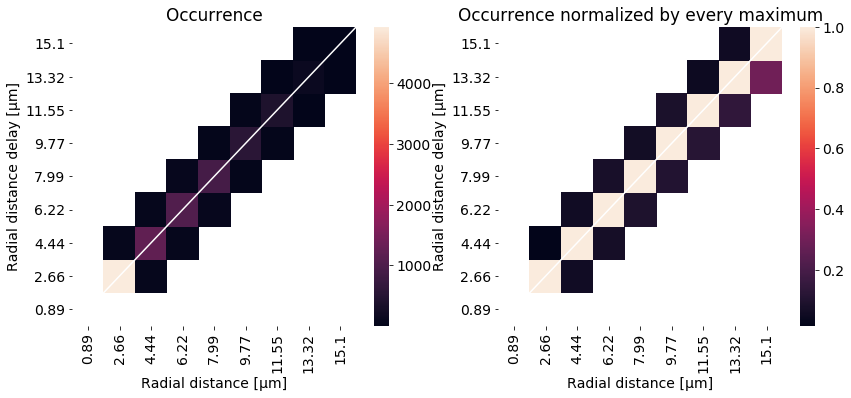

In [43]:
shellcount = np.zeros((steps,steps))
start_time = time.time()    
for i in range(back,maxlength):
    for j in range(steps):
        if radialdistance[i] < radialhist[j,0] and radialdistance[i] > radialhist[j-1,0]:
            for k in range(steps):
                if radialdistance[i-back] < radialhist[k,0] and radialdistance[i-back] > radialhist[k-1,0]:
                    shellcount[k,j] += 1
print("--- %s seconds ---" % round((time.time() - start_time),2))
for i in range(steps):
    for j in range(steps):
        if shellcount[j,i] == 0: shellcount[j,i] = np.nan
shellcount2 = shellcount.copy()
for i in range(steps): shellcount2[:,i] /= np.nanmax(shellcount2[:,i])

fig= plt.figure(figsize=(14, 5.5))
plt.subplot(1,2,1)
df = pd.DataFrame(shellcount[1:,1:], columns=plotdist[1:], index=plotdist[1:])
p1 = sns.heatmap(df)
plt.plot(plotdist,plotdist, c = 'w')
plt.xlabel('Radial distance [µm]')
plt.ylabel('Radial distance delay [µm]')
plt.title('Occurrence')
p1.invert_yaxis()
plt.subplot(1,2,2)
df = pd.DataFrame(shellcount2[1:,1:], columns=plotdist[1:], index=plotdist[1:])
p1 = sns.heatmap(df)
plt.plot(plotdist,plotdist, c = 'w')
plt.xlabel('Radial distance [µm]')
plt.ylabel('Radial distance delay [µm]')
plt.title('Occurrence normalized by every maximum')
p1.invert_yaxis()
plt.savefig('Velocity and drift distributionnew'+str(number)+'.pdf', format='pdf')
plt.show()